# Предсказание заблокированных операций



**Титоренко Антой Александрович**

## Описание проекта

**Вводные**: *Операция клиента может быть заблокирована банком по требованию 115-ФЗ.* Исходя из истории предыдущих транзакций, атрибутов карточки клиента и некоторых показателей риска, учитывающих прошлые блокировки, нужно решить задачу бинарной классификации: определить, будут ли у клиента в конкретную дату операции, требующие блокировки.

*Представленные данные являются синтетическими, но они созданы на основе реальных данных и учитывают все закономерности, фактические распределения и влияние признаков.*

**Задача**: предсказать у каких клиентов будут блокировки.



**Files**
- train.csv - the training set
- test.csv - the test set
- client_measures.csv - признаки клиента на дату trigger_dt
- transactions.csv - транзакции клиента за 180 дней

**Columns**
- reg_code - код региона
- activity_code - код вида деятельности
- trxn_direction - направление транзакции (списание или зачисление)
- trxn_date - дата транзакции
- trxn_ammount - сумма транзакции

Остальные признаки не раскрываются.

## План работы

* Шаг 1: загрузка данных
  - загрузим датасеты и выполним первычный осмотр
* Шаг 2: Исследовательский анализ и предобработка
  - Выполним исследовательский анализ каждого датафрейма, при необходимости проведем предобработку
* Шаг 3: Подготовка данный к анализу
* Шаг 4: Обучение моделей машинного обучения
* Шаг 5: Выбор лучшей модели по метрике roc-auc на тестовой выборке
* Шаг 6: Общий вывод

## Этап 1. Исследовательский анализ данных

### Загрузим библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
!pip install catboost
from catboost import CatBoostClassifier

# раюота с lstm
import tensorflow as tf
from sklearn.metrics import roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping

# подбор параметров
!pip install optuna
import optuna

# для построения пайплайна
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

#оценка качества
from sklearn.metrics import roc_auc_score

!pip install mlxtend
from mlxtend.feature_selection import SequentialFeatureSelector as SFS


import os
import time
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

RANDOM_STATE = 42


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 9.2 MB/s eta 0:00:00


### Загрузим данные

In [2]:

def load_and_read_file(filename):
    '''
    Напишем функцию для загрузки файлов.
    Если их нет в директории, то качаем с кагла.
    Предварительно нужно убедиться, что kaggle.json в директории
    '''
    try:
        return pd.read_csv(filename)
    except FileNotFoundError:
        if not os.path.isfile(filename):
            print(f"{filename} не найден. Загрузка с Kaggle")
            !kaggle competitions download -c compl-sber-ds-test
            !unzip compl-sber-ds-test.zip
        return pd.read_csv(filename)


In [3]:
!ls -lha kaggle.json

ls: cannot access 'kaggle.json': No such file or directory


Тут нужно вставить скачанный kaggle.json
https://www.kaggle.com/docs/api

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')
from google.colab import files

files.upload() #грузим

Mounted at /content/gdrive


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"antonti012","key":"d902279124d60fee318901fc78e34668"}'}

In [5]:
!ls -lha kaggle.json
!pip install -q kaggle


-rw-r--r-- 1 root root 66 Apr 14 18:58 kaggle.json


In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [7]:
!chmod 600 /root/.kaggle/kaggle.json

In [8]:

# читаем данные
client_measures = load_and_read_file('client_measures.csv')
transactions = load_and_read_file('transactions.csv')
train = load_and_read_file('train.csv')
test = load_and_read_file('test.csv')

client_measures.csv не найден. Загрузка с Kaggle
 81% 5.00M/6.21M [00:00<00:00, 47.2MB/s]
100% 6.21M/6.21M [00:00<00:00, 56.0MB/s]
Archive:  compl-sber-ds-test.zip
  inflating: client_measures.csv     
  inflating: test.csv                
  inflating: train.csv               
  inflating: transactions.csv        


### Посмотрим на данные

In [10]:
# функция для первичного просмотра датасета
def first_view(data):
  print(f"Размер датасета: {data.shape}\n")

  print("Типы данных и пропущенные значения:")
  print(data.info(), "\n")

  print("Статистики для числовых признаков:")
  print(data.describe(), "\n")

  print("Уникальные значения для категориальных признаков:")
  categorical_columns = data.select_dtypes(include=['object', 'category']).columns
  unique_values = data[categorical_columns].nunique()
  print(unique_values)



In [11]:
# Функция для подсчета пропущенных значений
def missing_values_percentage(data):
  missing_percentage = data.isnull().sum() * 100 / len(data)
  missing_percentage = missing_percentage[missing_percentage > 0].sort_values(ascending=False)
  return missing_percentage


**client_measures**

Колонки:
- client_id - клиентский id
- days_from_start - количество дней с регистрации
- reg_code - код региона
- activity_code - код вида деятельности

In [12]:
client_measures

,client_id,days_from_start,reg_code,activity_code,index_1,index_2,index_3,index_4
0,1,185.0,79.0,49.41,NaN,NaN,NaN,45.0
1,2,1932.0,79.0,43.21,NaN,0.0,NaN,NaN
2,3,9.0,79.0,47.91,NaN,0.0,NaN,NaN
3,4,19.0,79.0,41.20,NaN,NaN,NaN,NaN
4,5,48.0,80.0,1.41,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...
35194,35339,10.0,45.0,46.74,NaN,NaN,NaN,61.0
35195,35340,13.0,45.0,46.73,NaN,0.0,l3,66.0
35196,35341,69.0,45.0,46.90,NaN,0.0,l2,48.0
35197,35342,7.0,45.0,43.21,NaN,0.0,NaN,61.0


In [ ]:
first_view(client_measures)

Размер датасета: (35199, 8)

Типы данных и пропущенные значения:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35199 entries, 0 to 35198
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   client_id        35199 non-null  int64  
 1   days_from_start  35199 non-null  float64
 2   reg_code         35178 non-null  float64
 3   activity_code    35199 non-null  float64
 4   index_1          697 non-null    float64
 5   index_2          18727 non-null  float64
 6   index_3          9749 non-null   object 
 7   index_4          17287 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 2.1+ MB
None 

Статистики для числовых признаков:
          client_id  days_from_start      reg_code  activity_code     index_1  \
count  35199.000000     35199.000000  35178.000000   35199.000000  697.000000   
mean   17668.035342       561.765079     47.625362      49.067439    1.461980   
std    10201.913649 

In [ ]:
missing_values_percentage(client_measures)

index_1     98.019830
index_3     72.303190
index_4     50.887809
index_2     46.796784
reg_code     0.059661
dtype: float64

**Вывод:**

- Всего 35199 строк, 8 колонок;
- Все колонки, кроме index_3, имеют числовой тип данных. Колонка index_3 имеет тип данных object. Изуим в дальнейшем
-----
- Есть пропущенные значения в нескольких колонках:
  - reg_code 0.06% (21 пропущенное значение);
  - index_1 98% (34,502 пропущенных значений);
  - index_2 46.8% (16,472 пропущенных значений);
  - index_3 72.2% (25,450 пропущенных значений);
  - index_4 50.9% (17,912 пропущенных значений).
-----
- days_from_start имеет диапазон от 1 до 19,677 дней, в среднем 561, однако медиана на уровене 69 дней, что говорит о тяжелых правых хвостах в распределении;
- index_1, index_2, index_4 имеют различные распределения значений, некоторые из них имеют низкие средние значения и стандартные отклонения. Требуется проведение дополнительного анализа для понимания их влияния на модель;
- index_1 имеет 3 значения (кроме nan): 'l3', 'l2', 'l1'. Позже приведем к категориальным переменным.





**transactions.csv**

- trxn_direction - направление транзакции (списание или зачисление)
- trxn_date - дата транзакции
- trxn_ammount - сумма транзакции


В таблице transactions собраны данные за 180 дней, предшествующих trigger_dt.

In [ ]:
transactions

,client_id,trxn_direction,trxn_date,trxn_ammount,fl_0,fl_1,fl_2,fl_3,fl_4,fl_5,fl_6,fl_7,fl_8,fl_9,fl_10,fl_11,fl_12,fl_13,fl_14,fl_15,fl_16,fl_17,fl_18,fl_19,fl_20,fl_21,fl_22,fl_23,fl_24,fl_25,fl_26,fl_27,fl_28,fl_29,fl_30,fl_31,fl_32,fl_33,fl_34,fl_35,fl_36,fl_37,fl_38,fl_39
0,23112,0,2023-12-26,2.79757,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,23112,1,2023-12-27,2.79757,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0
2,20472,1,2023-12-01,2.00785,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,20472,0,2023-11-28,2.75568,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0
4,20472,0,2023-11-23,2.46082,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
737903,8070,1,2023-05-19,2.22940,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0
737904,8070,1,2023-05-19,0.14583,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
737905,29319,1,2023-03-16,1.95547,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
737906,29319,1,2023-03-16,2.42167,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0


In [ ]:
first_view(transactions)

Размер датасета: (737908, 44)

Типы данных и пропущенные значения:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737908 entries, 0 to 737907
Data columns (total 44 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   client_id       737908 non-null  int64  
 1   trxn_direction  737908 non-null  int64  
 2   trxn_date       737908 non-null  object 
 3   trxn_ammount    737908 non-null  float64
 4   fl_0            737908 non-null  int64  
 5   fl_1            737908 non-null  int64  
 6   fl_2            737908 non-null  int64  
 7   fl_3            737908 non-null  int64  
 8   fl_4            737908 non-null  int64  
 9   fl_5            737908 non-null  int64  
 10  fl_6            737908 non-null  int64  
 11  fl_7            737908 non-null  int64  
 12  fl_8            737908 non-null  int64  
 13  fl_9            737908 non-null  int64  
 14  fl_10           737908 non-null  int64  
 15  fl_11           737908 non-null  in

In [ ]:
missing_values_percentage(transactions)

Series([], dtype: float64)

**Вывод:**
- Датасет состоит из 737908 строк и 44 колонок
- Формат у trxn_date object, следует перевести позже
- Пропусков нет
- Флаги f1_1 - f1_39 принимают значения 0/1. Пока не понятно, что делать с ними. Скорее всего, они свидетельствуют о характеристиках транзакций

**train**

In [ ]:
train

,client_id,trigger_dt,target
0,2,2023-06-26,0
1,3,2023-04-23,0
2,4,2023-10-03,0
3,5,2023-07-06,0
4,6,2023-07-03,0
...,...,...,...
26000,35338,2023-03-07,0
26001,35339,2023-01-27,1
26002,35341,2023-06-26,1
26003,35342,2023-06-07,1


In [ ]:
first_view(train)

Размер датасета: (26005, 3)

Типы данных и пропущенные значения:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26005 entries, 0 to 26004
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   client_id   26005 non-null  int64 
 1   trigger_dt  26005 non-null  object
 2   target      26005 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 609.6+ KB
None 

Статистики для числовых признаков:
          client_id        target
count  26005.000000  26005.000000
mean   17657.816958      0.282715
std    10212.598907      0.450328
min        2.000000      0.000000
25%     8841.000000      0.000000
50%    17659.000000      0.000000
75%    26537.000000      1.000000
max    35343.000000      1.000000 

Уникальные значения для категориальных признаков:
trigger_dt    299
dtype: int64


In [ ]:
missing_values_percentage(train)

Series([], dtype: float64)

**Вывод:**

- Датасет содержит 26005 записей и 3 колонки;
- Пропусков нет;
- trigger_dt имеет тип object, надо в даты перевести
- target целевой признак, имеет бинарный тип данных, 1 - подозрительный клиент, 0 - нет.  Единиц 28.27%. Следовательно, нужно будет сбалансировать данные



----
**test**

*Условное* завтра для клиентов, требуется на основании истории дать вероятность, с которой следует отправить клиента на доп проверку

In [ ]:
test

,client_id,trigger_dt
0,1,2023-10-27
1,7,2023-12-22
2,9,2023-11-10
3,17,2023-11-14
4,18,2023-11-28
...,...,...
9189,35322,2023-12-25
9190,35325,2023-08-17
9191,35327,2023-05-18
9192,35332,2023-11-03


____

Привежем признаки с датами в формат дат

In [9]:
def change_date_format(data, column):
  data[column] = pd.to_datetime(data[column], format='%Y-%m-%d')

change_date_format(transactions, 'trxn_date')
change_date_format(train, 'trigger_dt')
change_date_format(test, 'trigger_dt')

### Графики

Напишем функцию **numeric_feature_distribution**, строящую графики распределения числовых признаков

In [ ]:
def feature_distribution(data, features):
    plt.figure(figsize=(15, 5 * len(features)))
    for i, feature in enumerate(features):
        plt.subplot(len(features), 1, i + 1)
        sns.histplot(data[feature], bins=30)
        plt.title(f'Распределение для {feature}')
        plt.xlabel(feature)
        plt.ylabel('Количество')

    plt.tight_layout()
    plt.show()

Напишем функцию **categorical_feature_distribution**, строящую графики распределения категориальных признаков

In [ ]:
def categorical_feature_distribution(data, feature):
  plt.figure(figsize=(10, 5))
  sns.countplot(x=feature, data=data)
  plt.title(f'Распределение для {feature}')
  plt.xlabel(feature)
  plt.ylabel('Количество')
  plt.xticks(rotation=45)
  plt.show()


#### Применим к **client_measures**

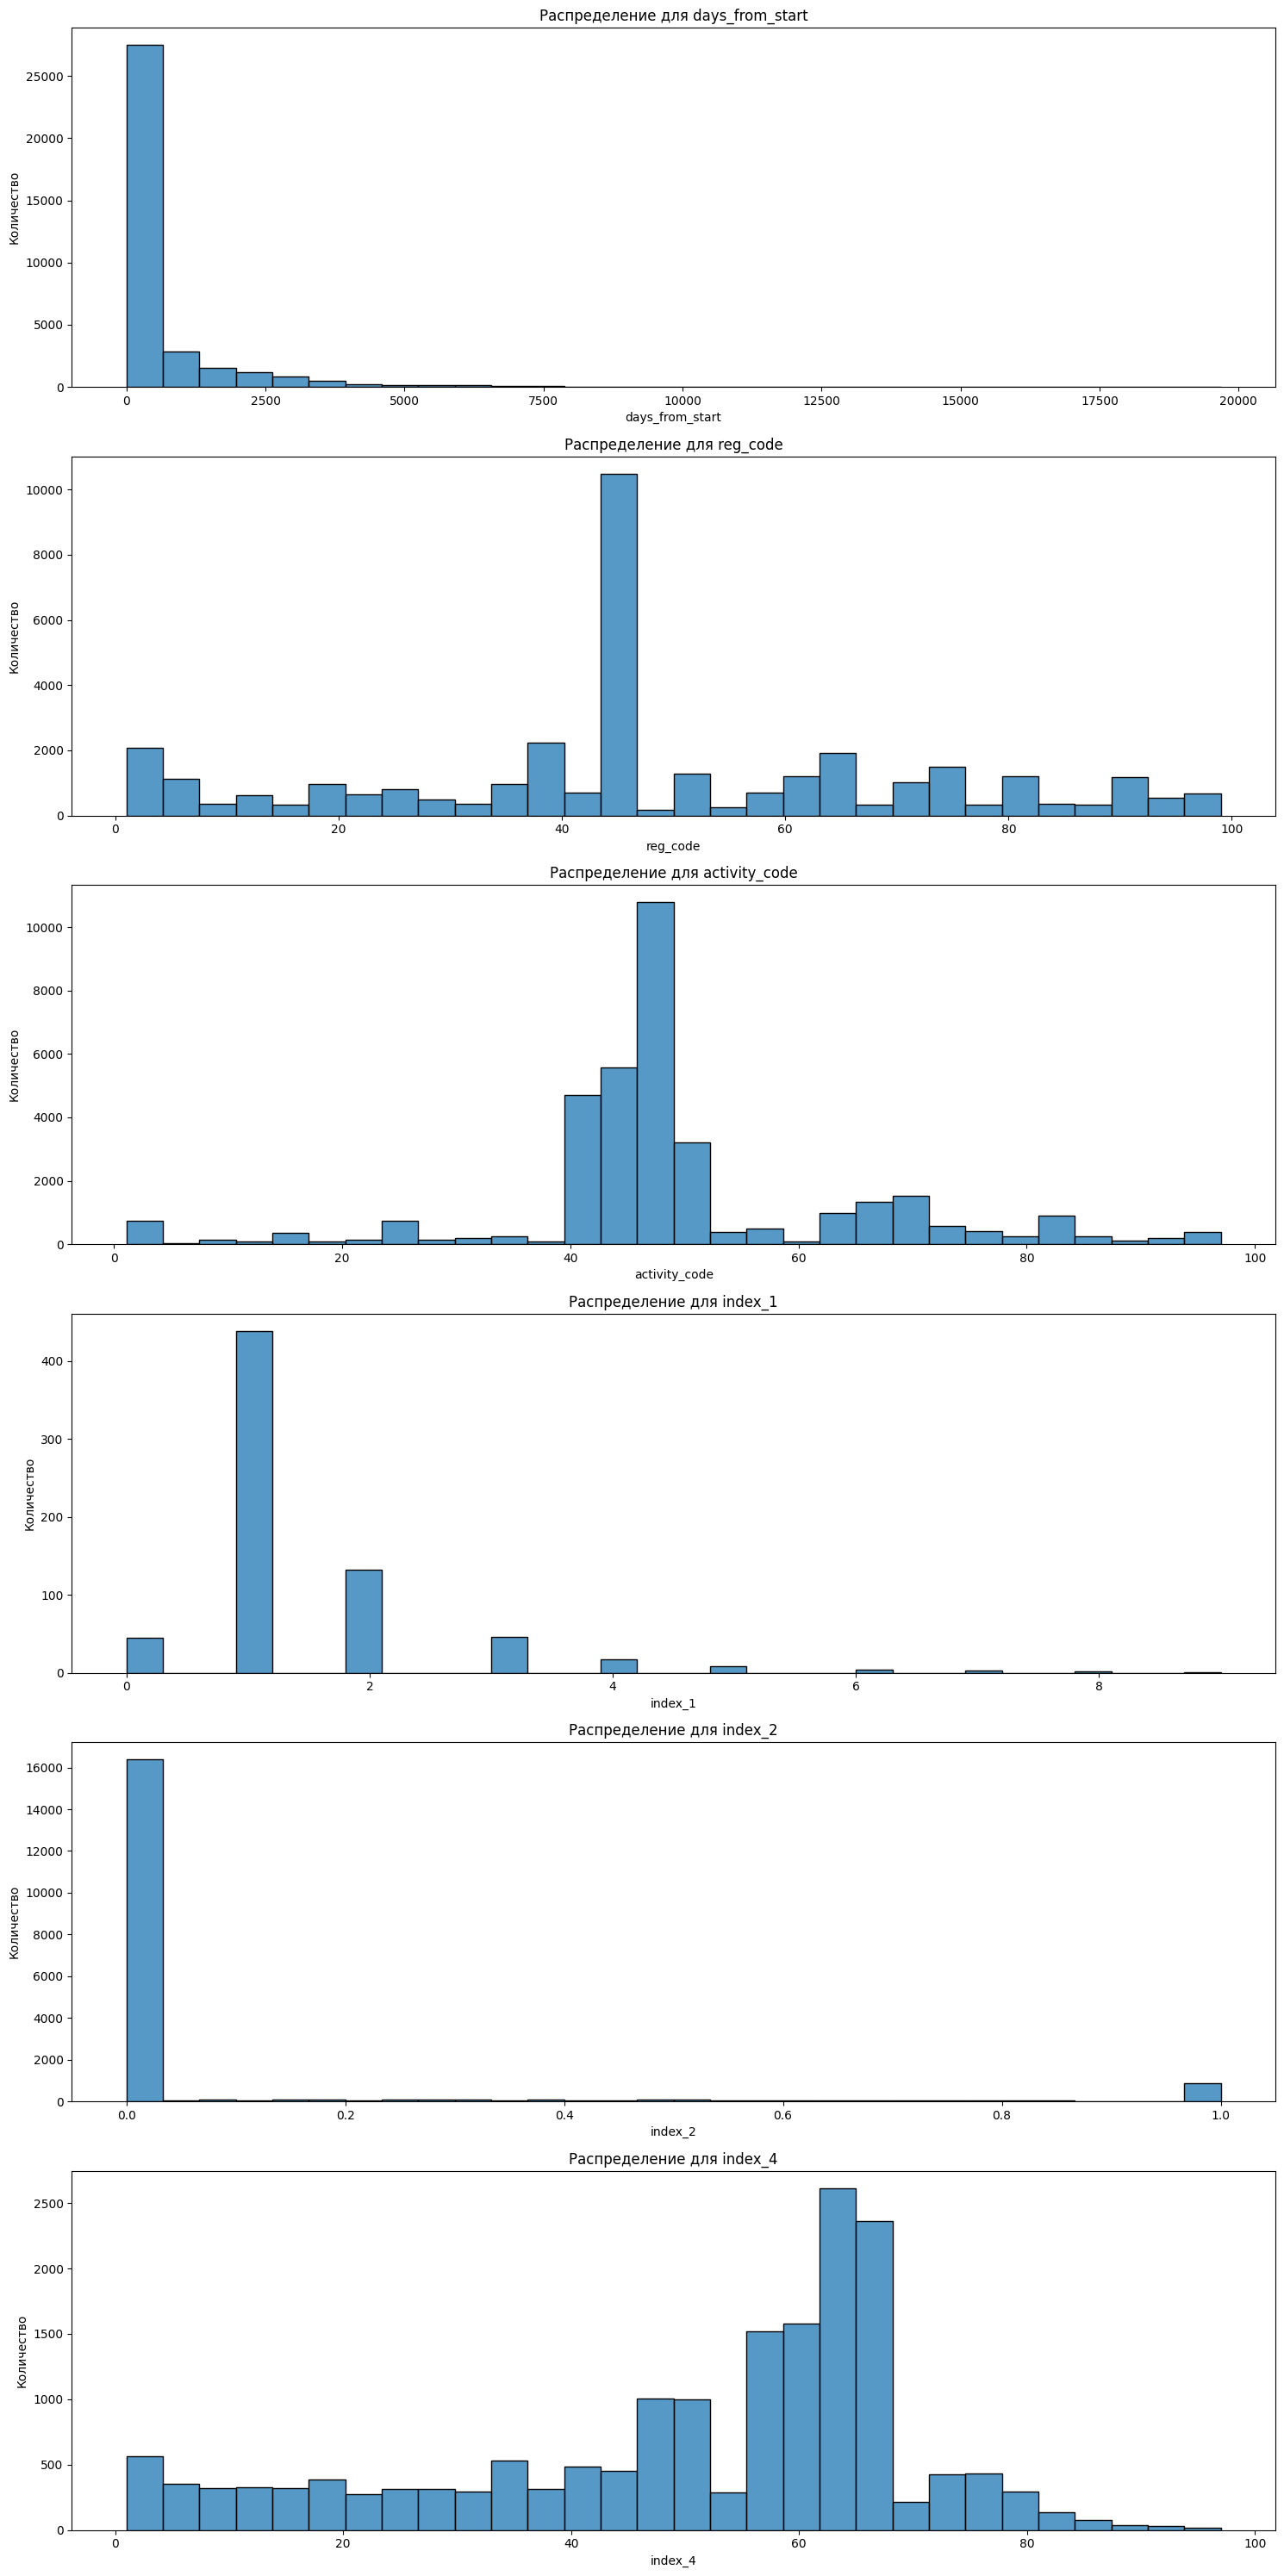

In [ ]:
features = ['days_from_start', 'reg_code', 'activity_code', 'index_1', 'index_2', 'index_4']
feature_distribution(client_measures, features)

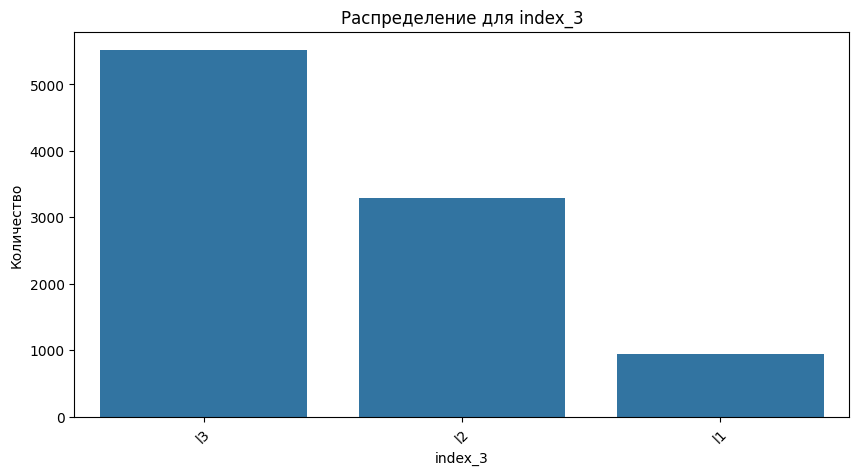

In [ ]:
categorical_feature_distribution(client_measures, 'index_3')


#### Применим к **transactions**

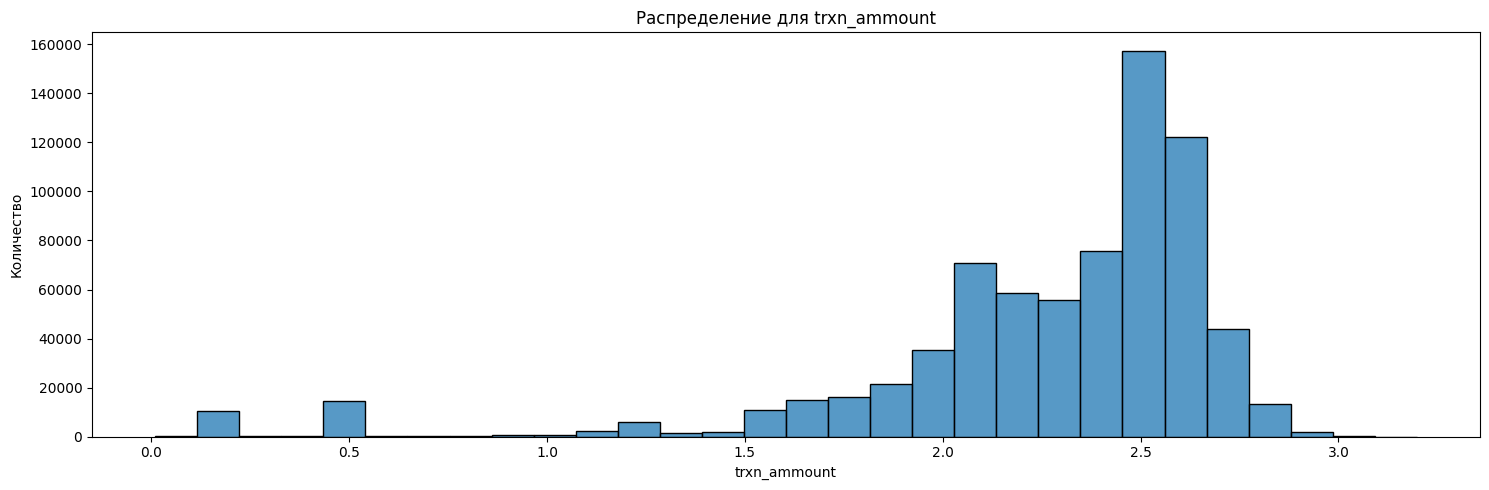

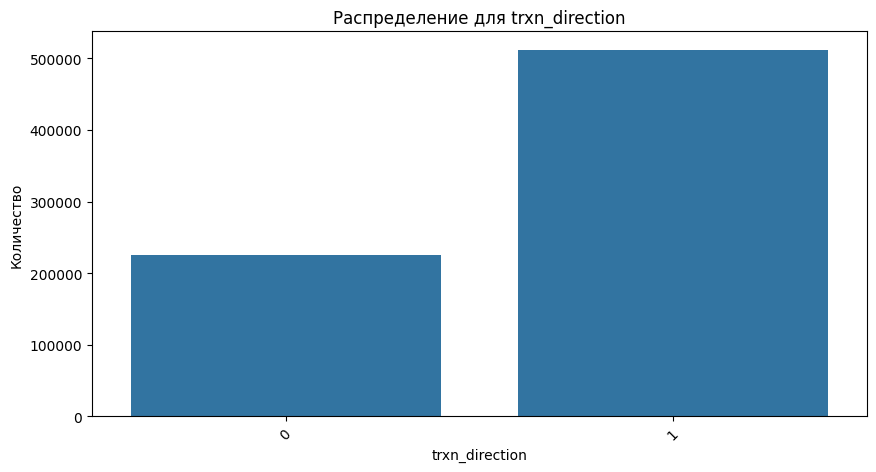

In [ ]:
numerical_features = ['trxn_ammount']
feature_distribution(transactions, numerical_features)

categorical_feature_distribution(transactions, 'trxn_direction')


Транзакции распределены относительно нормально с длинным хвостом справа, среднее значение и медиана практически совпадают

Относительно trxn_direction, зачислений (1) значительно больше чем списаний (0). Эта информация может быть полезна для анализа поведения клиентов и тенденций в транзакционной активности.

#### Применим к train

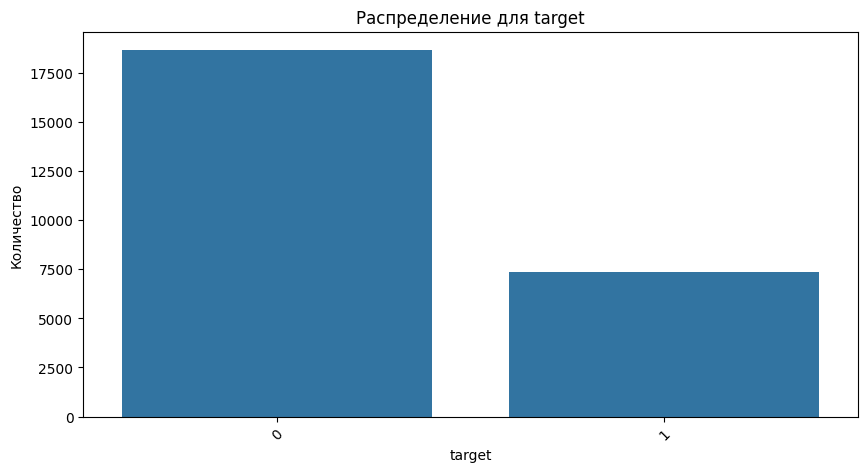

In [ ]:
categorical_feature_distribution(train, 'target')


### Этап 2. Подготовка даннных для моделей

#### **Объедим в один датафрейм df**



**Объединяем в общий датафрейм тренировочную**

In [13]:
def prepare_aggregates_train(transactions, client_measures, train):

    aggregated_features_list = []

    # Получаем список флагов
    flag_columns = [col for col in transactions.columns if col.startswith('fl_')]

    # отбираем всех клиентов из train
    unique_clients = train['client_id'].unique()

    for client_id in unique_clients:
        client_transactions = transactions[transactions['client_id'] == client_id]
        trigger_date = train[train['client_id'] == client_id]['trigger_dt'].iloc[0]

        # фильтруем данные до trigger_dt
        client_transactions_before_trigger = client_transactions[client_transactions['trxn_date'] < trigger_date]

        # сделаем доп фичи, которые будут отражать историю клиента до триггер даты
        total_amount = client_transactions_before_trigger['trxn_ammount'].sum()
        transaction_count = client_transactions_before_trigger.shape[0]
        average_amount = client_transactions_before_trigger['trxn_ammount'].mean() if transaction_count > 0 else 0
        std_amount = client_transactions_before_trigger['trxn_ammount'].std() if transaction_count > 0 else 0
        income_count = client_transactions_before_trigger[client_transactions_before_trigger['trxn_direction'] == 1].shape[0]
        outcome_count = client_transactions_before_trigger[client_transactions_before_trigger['trxn_direction'] == 0].shape[0]

        # Инициализация словаря для текущего клиента
        client_features = {
            'client_id': client_id,
            'total_amount': total_amount,
            'transaction_count': transaction_count,
            'average_amount': average_amount,
            'std_amount': std_amount,
            'income_count': income_count,
            'outcome_count': outcome_count
        }

        # агрегиуем флаги
        for col in flag_columns:
            client_features[col + '_sum'] = client_transactions_before_trigger[col].sum()

        aggregated_features_list.append(client_features)

    aggregated_features = pd.DataFrame(aggregated_features_list)
    # соединяем датафреймы
    data = pd.merge(train[['client_id', 'trigger_dt', 'target']], aggregated_features, on='client_id', how='left')
    data = pd.merge(data, client_measures, on='client_id', how='left')

    return data

# Подготовка датасета для обучения
data_train = prepare_aggregates_train(transactions, client_measures, train)
data_train

,client_id,trigger_dt,target,total_amount,transaction_count,average_amount,std_amount,income_count,outcome_count,fl_0_sum,fl_1_sum,fl_2_sum,fl_3_sum,fl_4_sum,fl_5_sum,fl_6_sum,fl_7_sum,fl_8_sum,fl_9_sum,fl_10_sum,fl_11_sum,fl_12_sum,fl_13_sum,fl_14_sum,fl_15_sum,fl_16_sum,fl_17_sum,fl_18_sum,fl_19_sum,fl_20_sum,fl_21_sum,fl_22_sum,fl_23_sum,fl_24_sum,fl_25_sum,fl_26_sum,fl_27_sum,fl_28_sum,fl_29_sum,fl_30_sum,fl_31_sum,fl_32_sum,fl_33_sum,fl_34_sum,fl_35_sum,fl_36_sum,fl_37_sum,fl_38_sum,fl_39_sum,days_from_start,reg_code,activity_code,index_1,index_2,index_3,index_4
0,2,2023-06-26,0,4.29247,2,2.146235,0.686735,1,1,0,0,1,0,0,0,0,1,2,1,0,0,0,0,0,0,0,2,2,0,1,0,0,0,0,1,0,0,0,0,2,1,0,0,0,0,0,0,0,0,1932.0,79.0,43.21,NaN,0.0,NaN,NaN
1,3,2023-04-23,0,2.68050,1,2.680500,NaN,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,9.0,79.0,47.91,NaN,0.0,NaN,NaN
2,4,2023-10-03,0,0.00000,0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19.0,79.0,41.20,NaN,NaN,NaN,NaN
3,5,2023-07-06,0,14.38256,10,1.438256,1.073802,6,4,0,0,0,0,0,0,0,2,8,6,2,2,0,0,0,0,0,10,10,0,8,0,0,0,0,0,0,0,0,0,10,1,0,0,0,0,0,0,0,0,48.0,80.0,1.41,NaN,0.0,NaN,NaN
4,6,2023-07-03,0,4.10735,2,2.053675,0.020216,1,1,0,0,0,0,0,0,0,1,2,1,0,0,0,0,0,0,0,2,2,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,707.0,80.0,49.41,NaN,0.0,NaN,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26000,35338,2023-03-07,0,52.57552,24,2.190647,0.601747,23,1,1,0,0,15,1,0,0,1,23,22,3,3,0,0,0,0,0,24,24,1,23,0,0,0,0,0,0,0,0,15,24,10,0,9,8,0,0,0,0,9,81.0,45.0,68.32,NaN,0.0,l3,55.0
26001,35339,2023-01-27,1,0.00000,0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.0,45.0,46.74,NaN,NaN,NaN,61.0
26002,35341,2023-06-26,1,11.75597,6,1.959328,0.492334,5,1,2,0,1,0,0,0,0,2,4,2,0,0,0,0,0,0,0,5,6,0,4,0,0,0,0,0,0,0,0,0,6,2,0,0,0,0,0,0,0,0,69.0,45.0,46.90,NaN,0.0,l2,48.0
26003,35342,2023-06-07,1,4.23979,2,2.119895,0.649485,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,2,2,0,1,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,7.0,45.0,43.21,NaN,0.0,NaN,61.0


Сейчас все сходится

In [ ]:
data_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26005 entries, 0 to 26004
Data columns (total 55 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   client_id          26005 non-null  int64         
 1   trigger_dt         26005 non-null  datetime64[ns]
 2   target             26005 non-null  int64         
 3   total_amount       26005 non-null  float64       
 4   transaction_count  26005 non-null  int64         
 5   average_amount     26005 non-null  float64       
 6   income_count       26005 non-null  int64         
 7   outcome_count      26005 non-null  int64         
 8   fl_0_avg           15793 non-null  float64       
 9   fl_1_avg           15793 non-null  float64       
 10  fl_2_avg           15793 non-null  float64       
 11  fl_3_avg           15793 non-null  float64       
 12  fl_4_avg           15793 non-null  float64       
 13  fl_5_avg           15793 non-null  float64       
 14  fl_6_a

In [14]:
numeric_columns = data_train.select_dtypes(include=['float64', 'int64']).columns.tolist()
numeric_columns.remove('client_id')


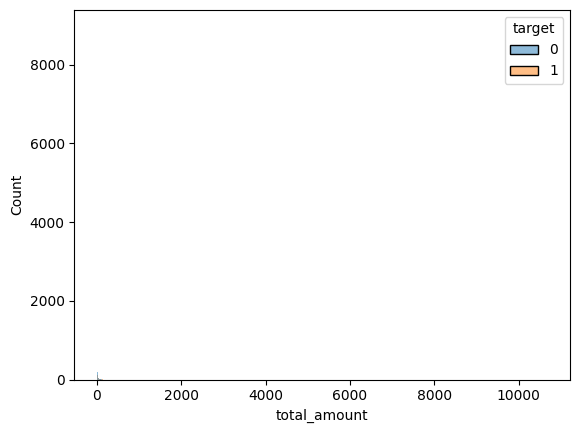

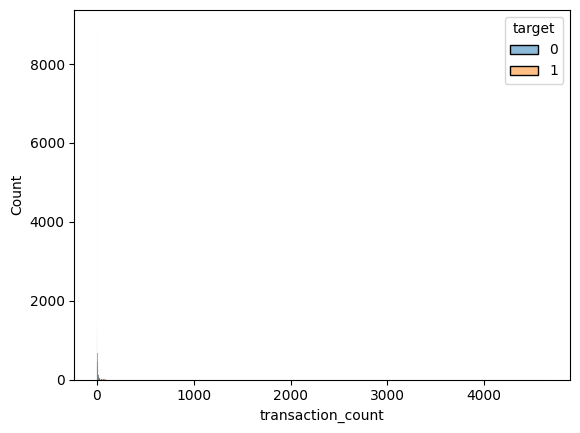

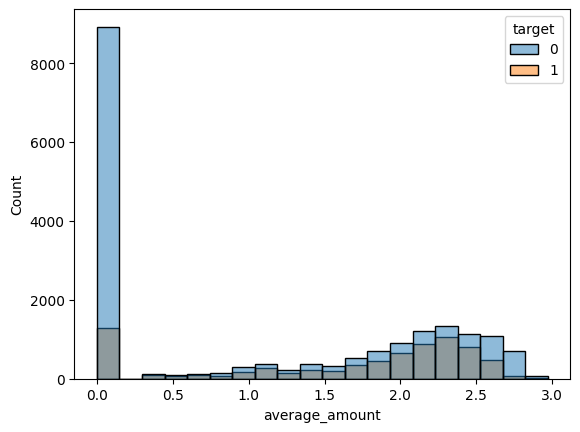

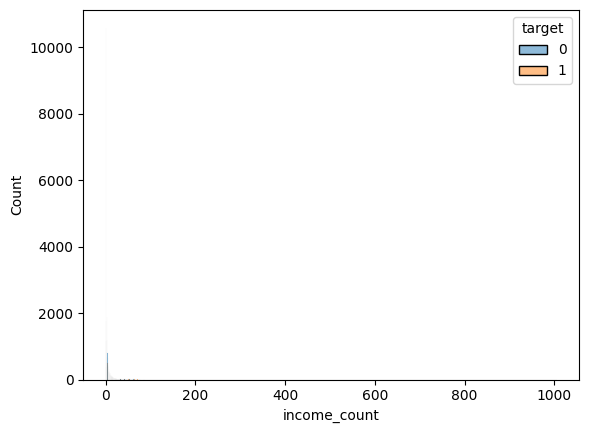

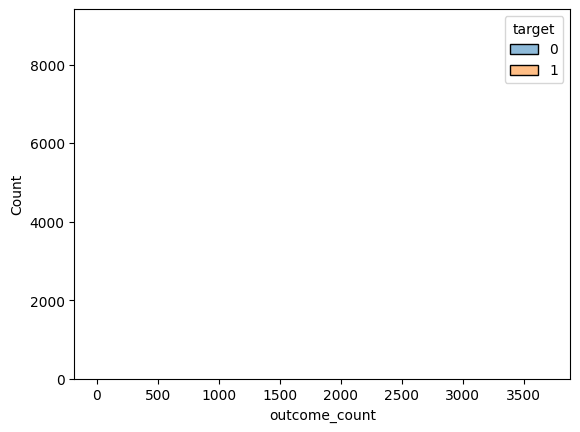

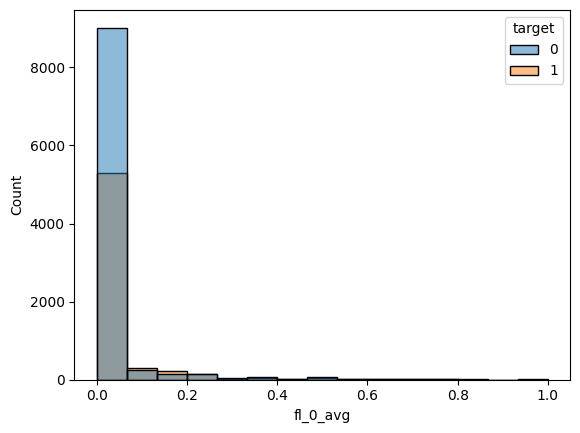

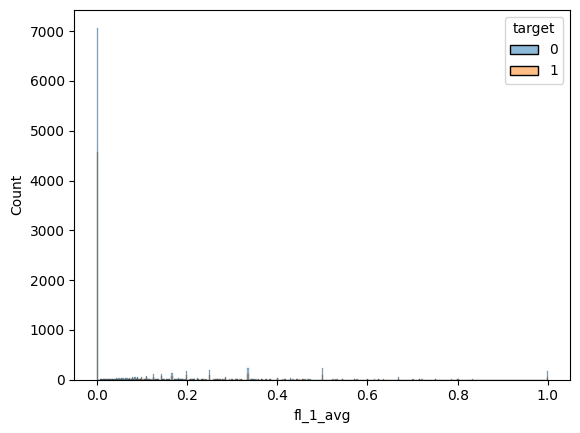

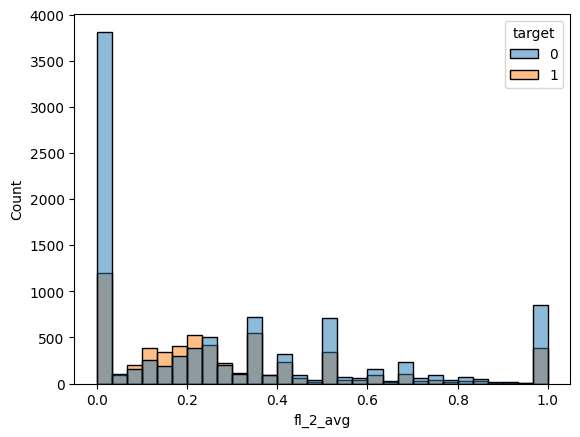

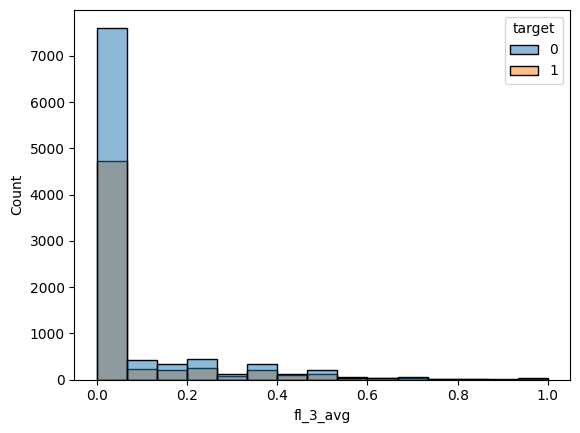

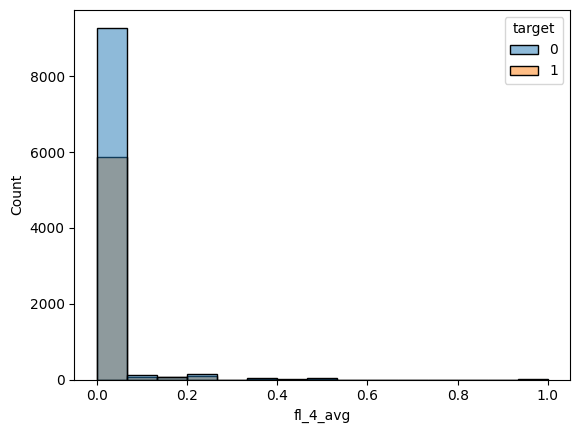

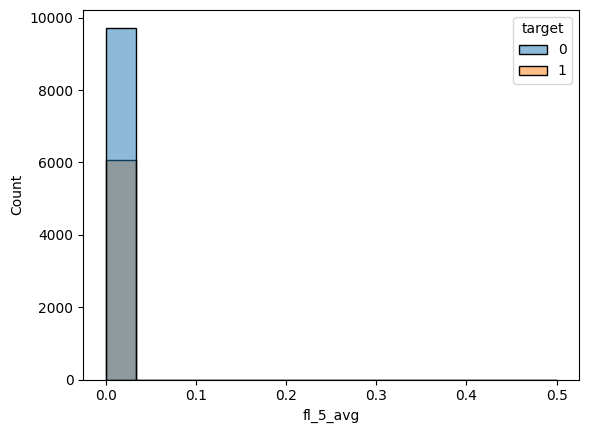

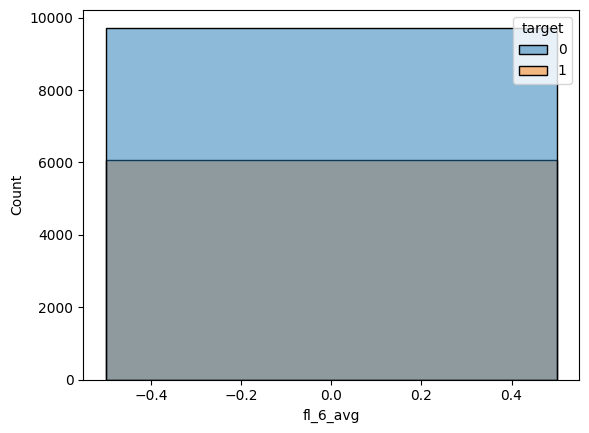

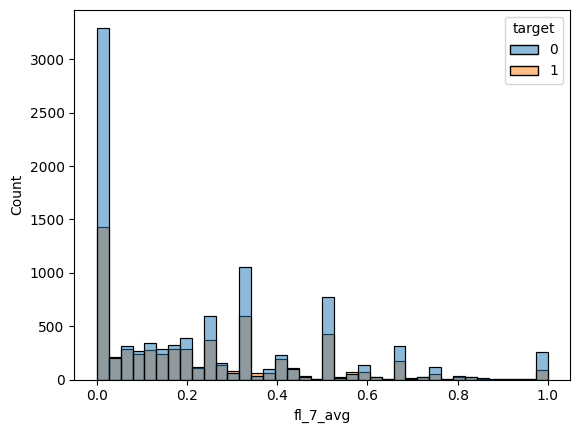

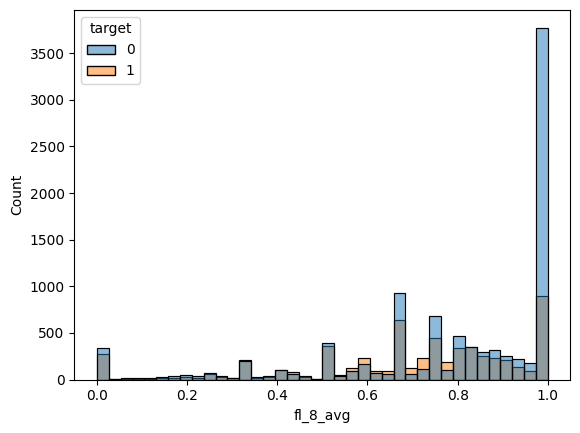

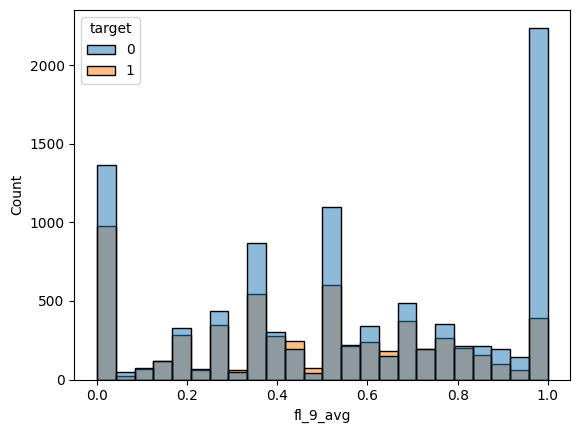

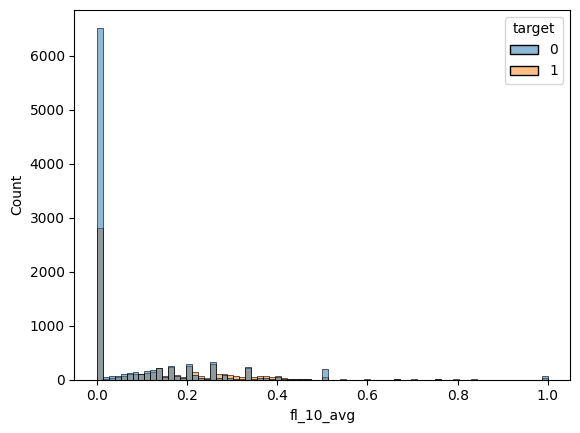

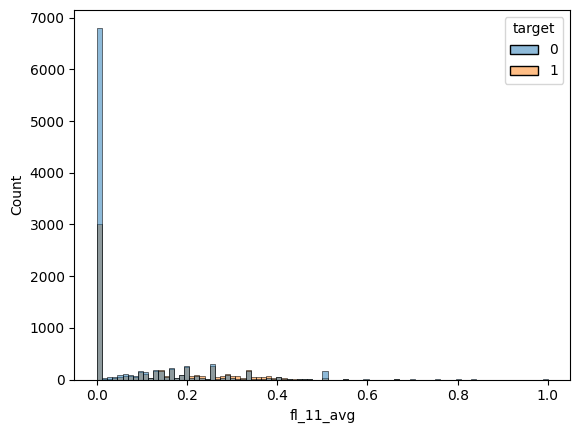

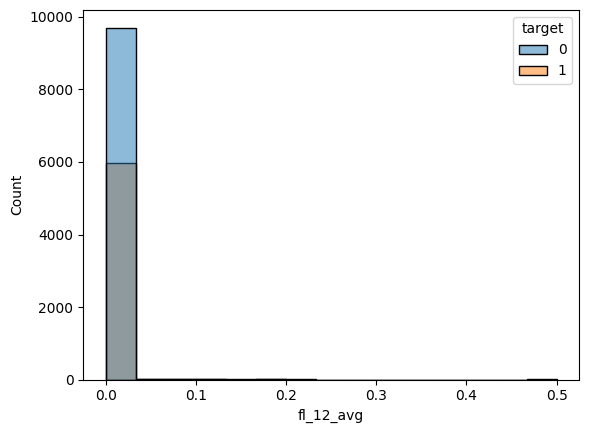

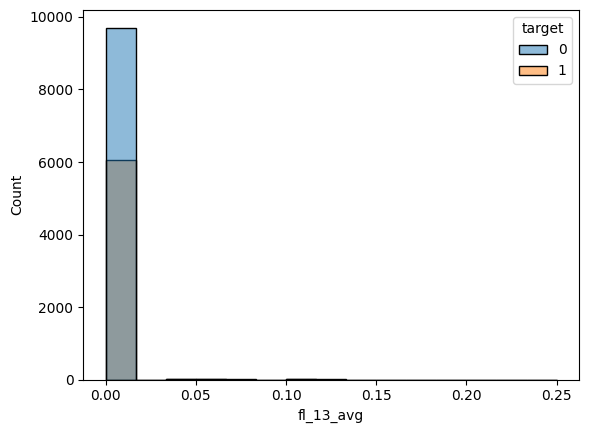

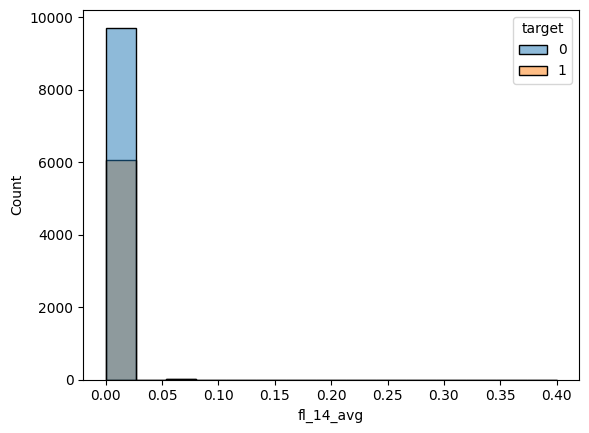

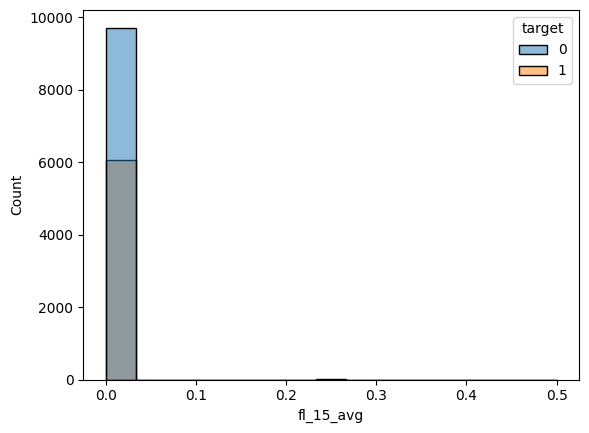

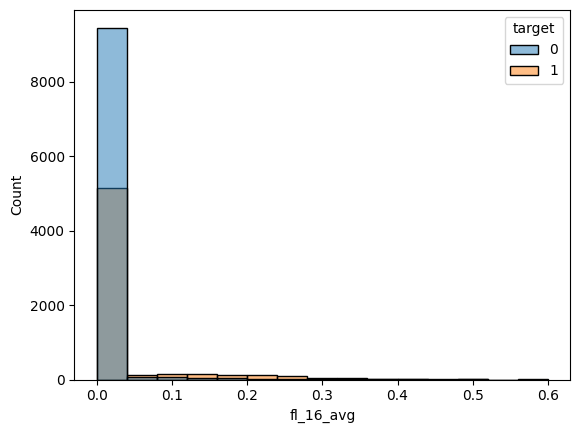

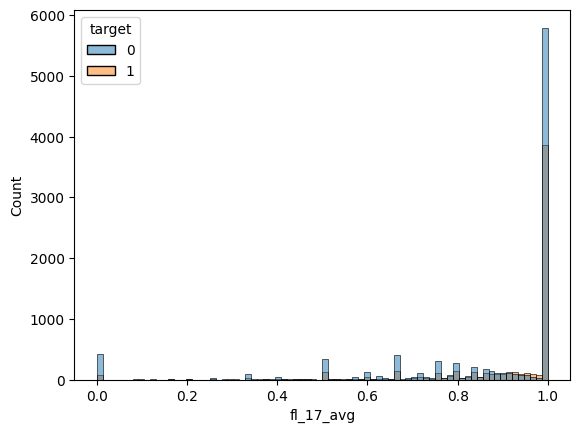

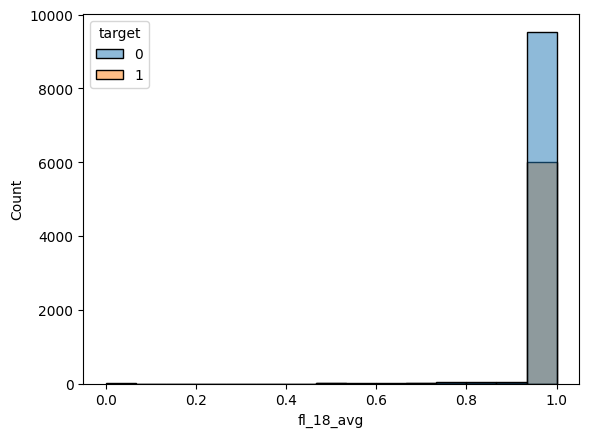

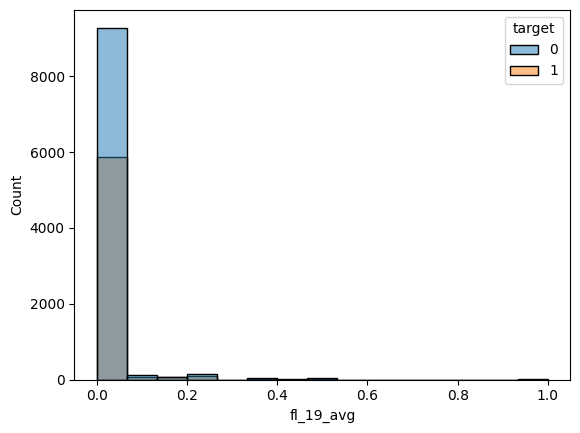

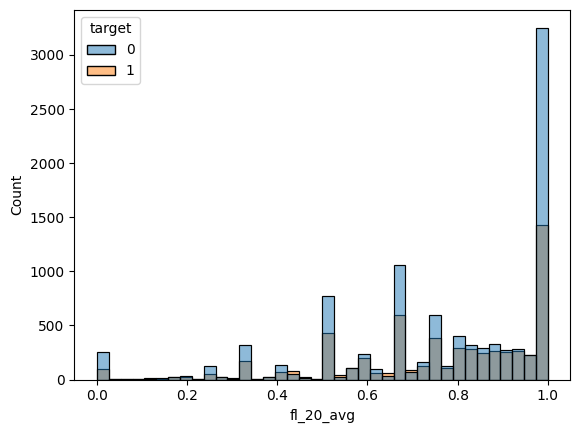

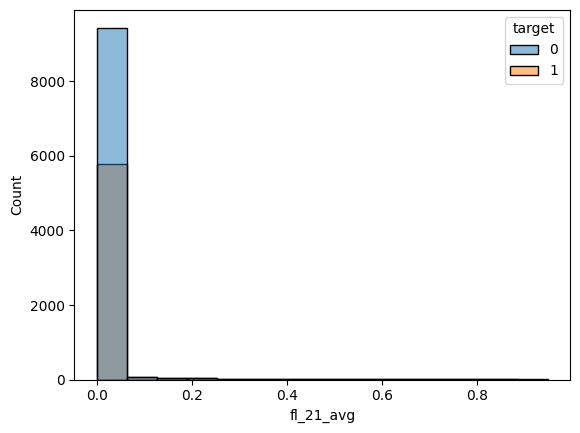

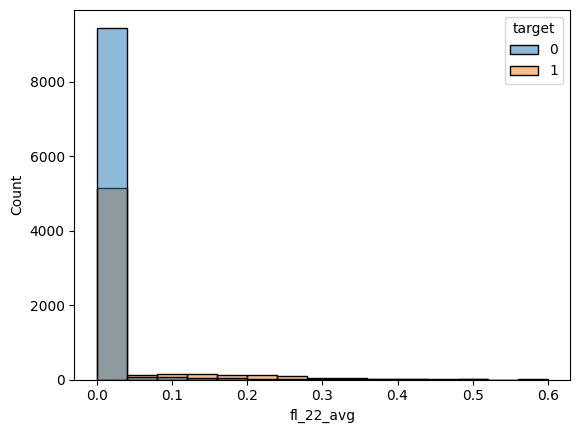

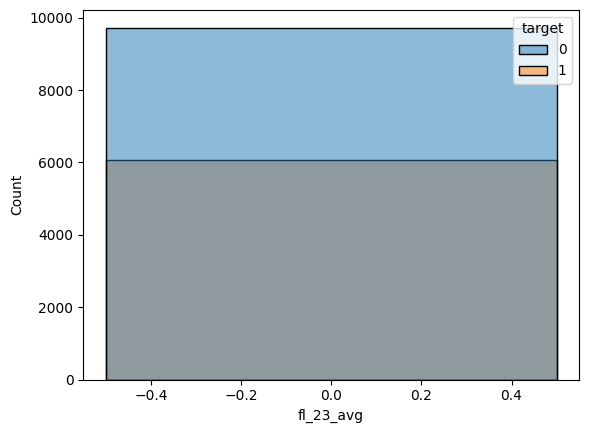

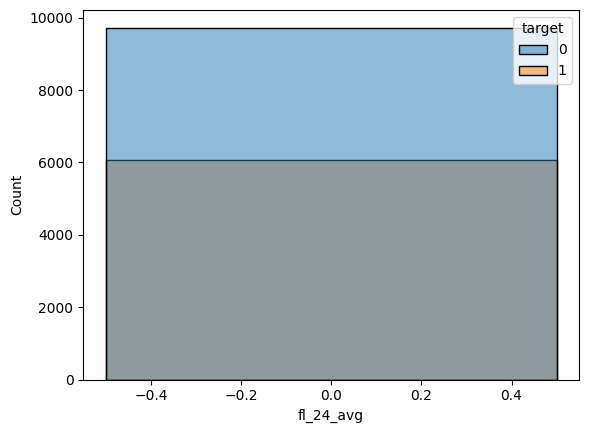

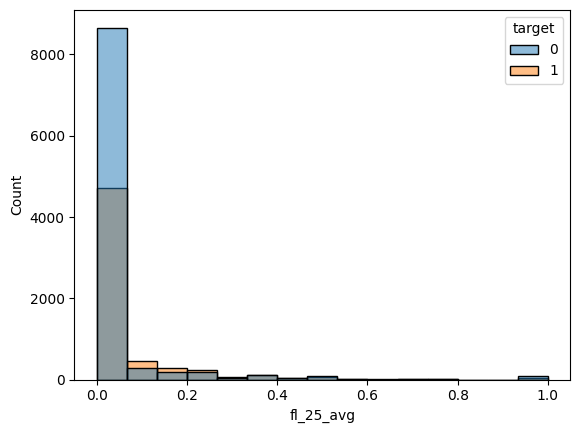

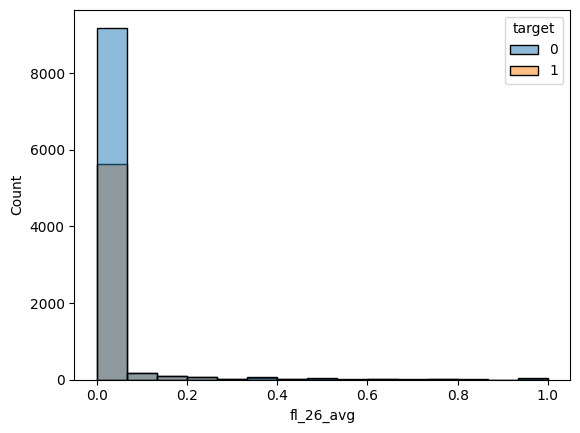

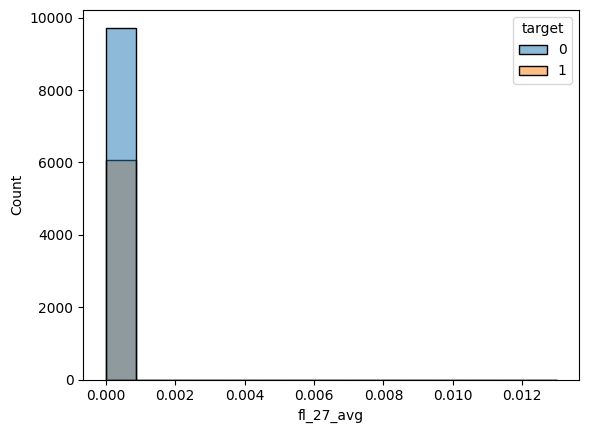

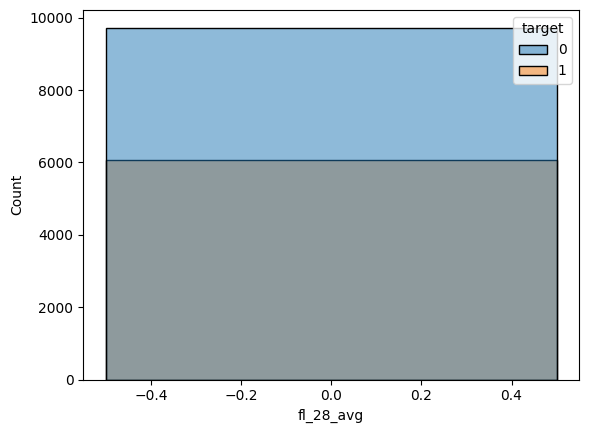

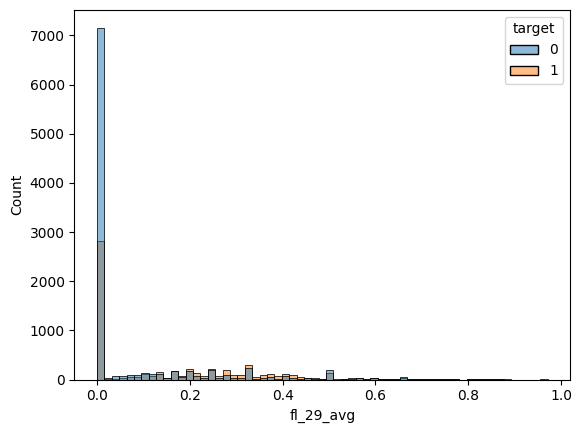

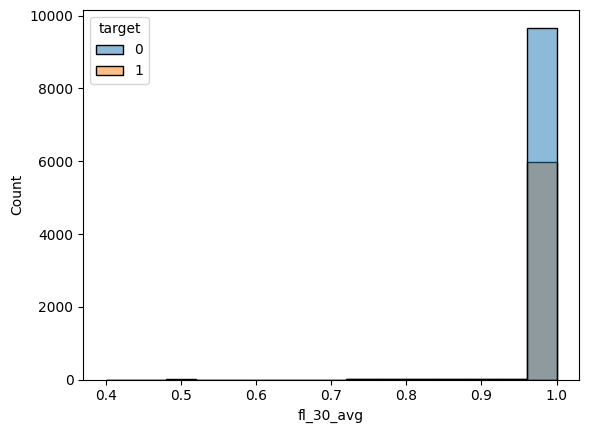

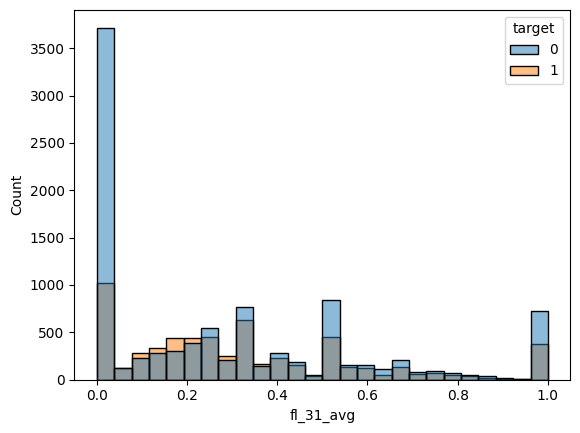

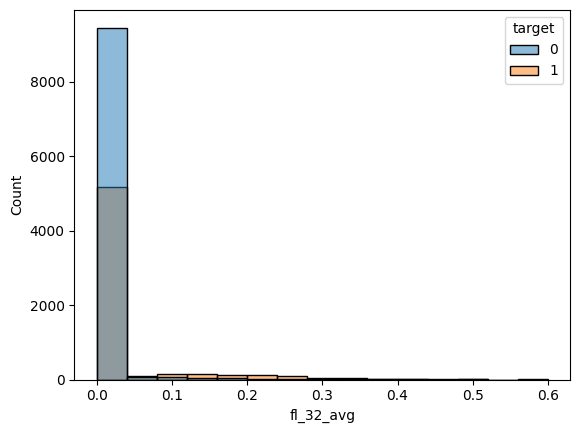

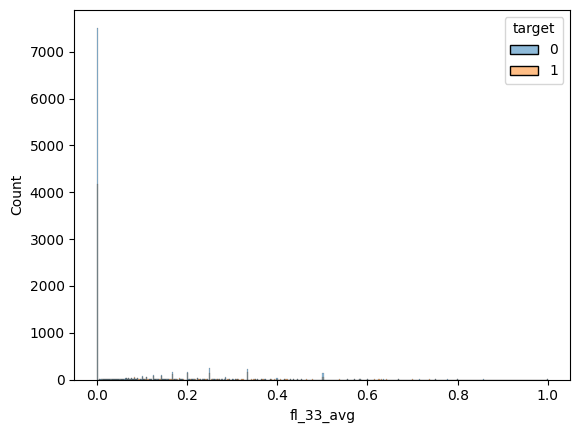

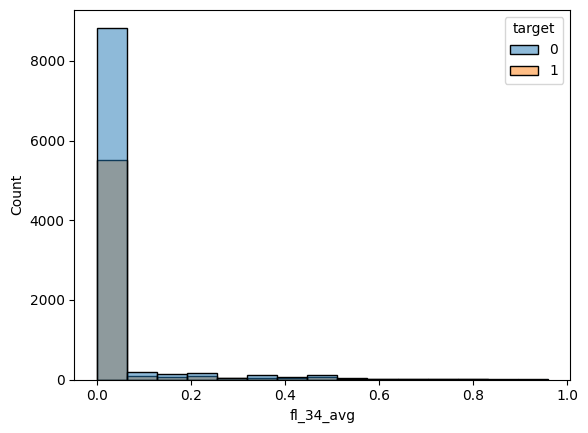

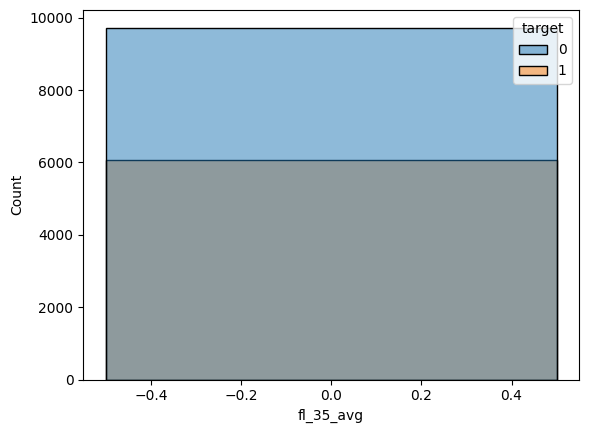

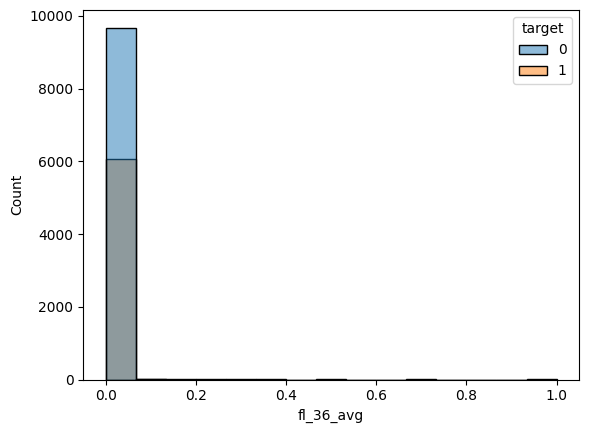

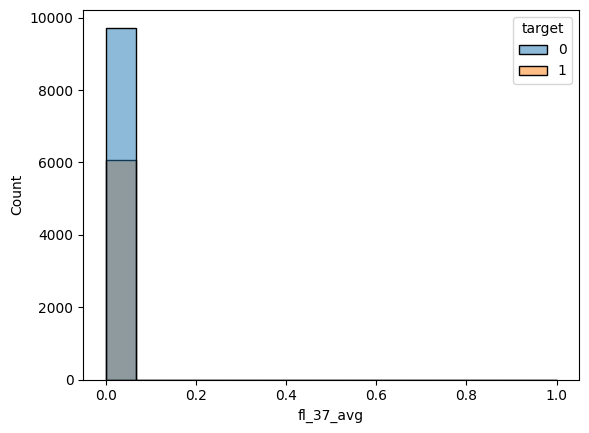

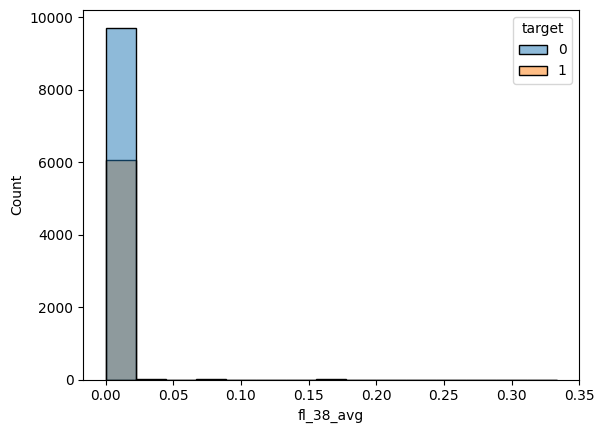

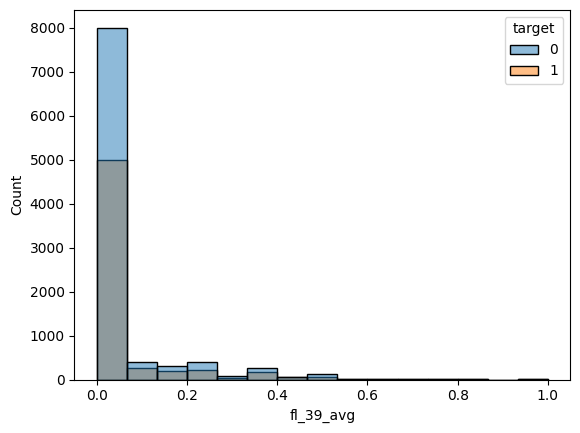

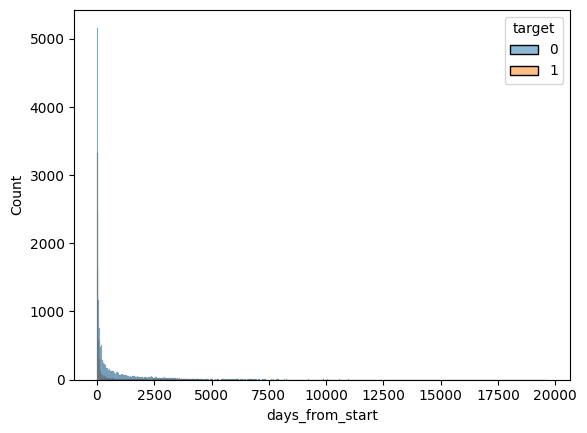

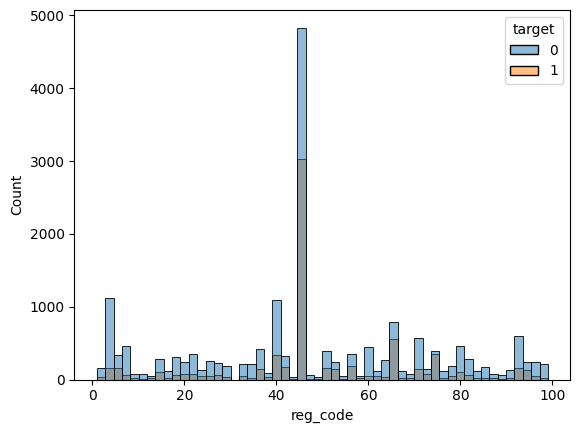

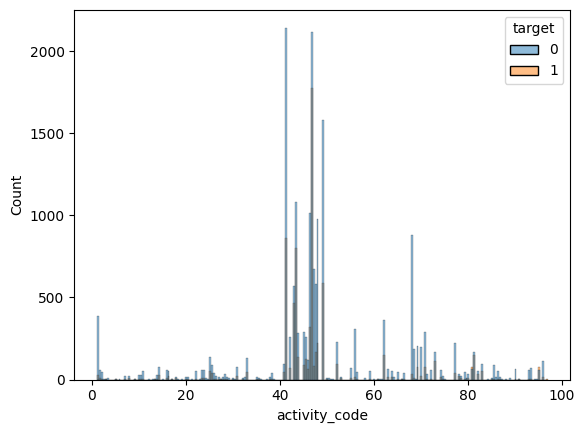

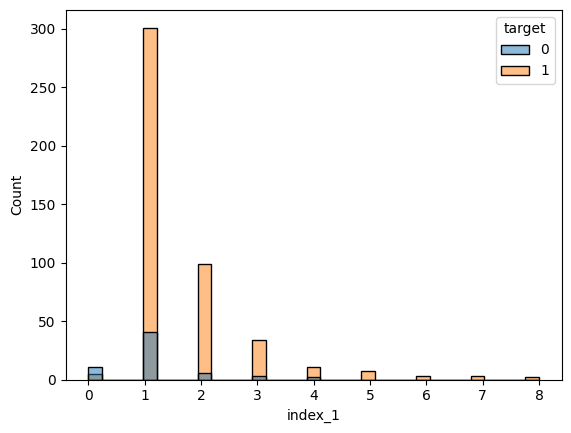

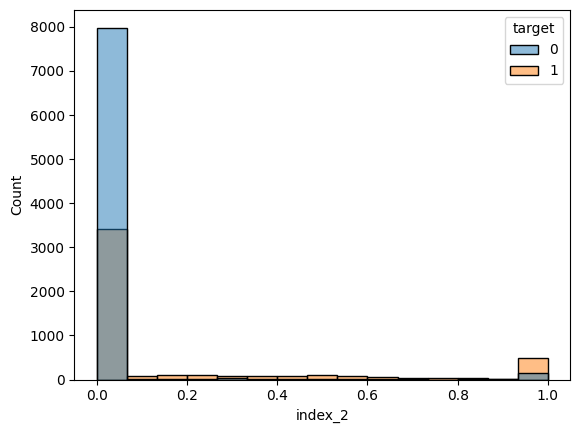

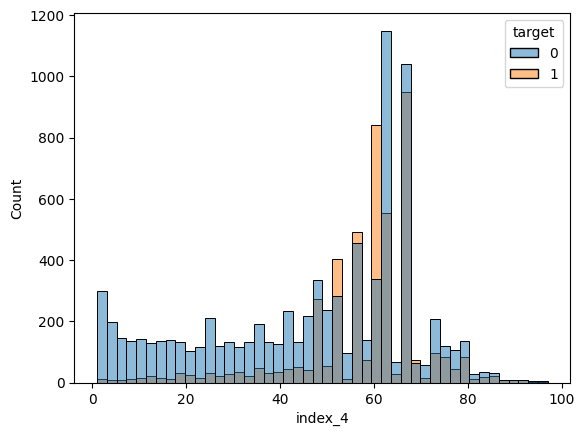

In [ ]:
# Посмотрим на распределение переменных относительно таргета

for column in numeric_columns:
    if column != 'target':
        sns.histplot(data=data_train, x=column, hue='target', alpha=0.5)
        plt.show()

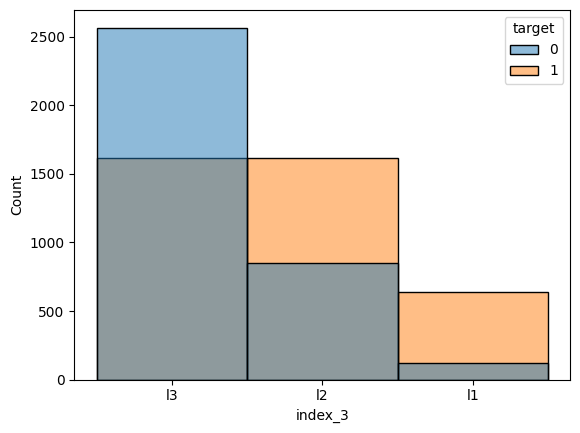

In [ ]:
sns.histplot(data=data_train, x='index_3', hue='target', alpha=0.5)
plt.show()

#### **Объедим в один датафрейм test**


Тоже самое для тестовой выборки

In [15]:
def prepare_aggregates_test(transactions, client_measures, test):
    # Инициализация списка для агрегированных признаков
    aggregated_features_list = []

    # Получаем список флагов
    flag_columns = [col for col in transactions.columns if col.startswith('fl_')]

    # Получаем уникальные client_id из test
    unique_clients = test['client_id'].unique()

    for client_id in unique_clients:
        client_transactions = transactions[transactions['client_id'] == client_id]
        trigger_date = test[test['client_id'] == client_id]['trigger_dt'].iloc[0]

        # Фильтрация транзакций до trigger_dt
        client_transactions_before_trigger = client_transactions[client_transactions['trxn_date'] < trigger_date]

        # Расчёт базовых агрегированных признаков
        total_amount = client_transactions_before_trigger['trxn_ammount'].sum()
        transaction_count = client_transactions_before_trigger.shape[0]
        average_amount = client_transactions_before_trigger['trxn_ammount'].mean() if transaction_count > 0 else 0
        std_amount = client_transactions_before_trigger['trxn_ammount'].std() if transaction_count > 0 else 0
        income_count = client_transactions_before_trigger[client_transactions_before_trigger['trxn_direction'] == 1].shape[0]
        outcome_count = client_transactions_before_trigger[client_transactions_before_trigger['trxn_direction'] == 0].shape[0]

        # Инициализация словаря для текущего клиента
        client_features = {
            'client_id': client_id,
            'total_amount': total_amount,
            'transaction_count': transaction_count,
            'average_amount': average_amount,
            'std_amount': std_amount,
            'income_count': income_count,
            'outcome_count': outcome_count
        }

        # Расчёт агрегированных признаков для флагов
        for col in flag_columns:
            client_features[col + '_sum'] = client_transactions_before_trigger[col].sum()

        aggregated_features_list.append(client_features)

    # Создание DataFrame из списка агрегированных признаков
    aggregated_features = pd.DataFrame(aggregated_features_list)

    # Добавление информации о trigger_dt и целевой переменной из test
    data = pd.merge(test[['client_id', 'trigger_dt']], aggregated_features, on='client_id', how='left')

    # Объединение агрегированных признаков с информацией о клиентах
    data = pd.merge(data, client_measures, on='client_id', how='left')



    return data

# Подготовка итогового датасета для тестирование
data_test = prepare_aggregates_test(transactions, client_measures, test)

In [16]:
set(data_train.columns.tolist()) - set(data_test.columns.tolist())

{'target'}

In [18]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26005 entries, 0 to 26004
Data columns (total 56 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   client_id          26005 non-null  int64  
 1   trigger_dt         26005 non-null  object 
 2   target             26005 non-null  int64  
 3   total_amount       26005 non-null  float64
 4   transaction_count  26005 non-null  int64  
 5   average_amount     26005 non-null  float64
 6   std_amount         24477 non-null  float64
 7   income_count       26005 non-null  int64  
 8   outcome_count      26005 non-null  int64  
 9   fl_0_sum           26005 non-null  int64  
 10  fl_1_sum           26005 non-null  int64  
 11  fl_2_sum           26005 non-null  int64  
 12  fl_3_sum           26005 non-null  int64  
 13  fl_4_sum           26005 non-null  int64  
 14  fl_5_sum           26005 non-null  int64  
 15  fl_6_sum           26005 non-null  int64  
 16  fl_7_sum           260

In [19]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9194 entries, 0 to 9193
Data columns (total 55 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   client_id          9194 non-null   int64  
 1   trigger_dt         9194 non-null   object 
 2   total_amount       9194 non-null   float64
 3   transaction_count  9194 non-null   int64  
 4   average_amount     9194 non-null   float64
 5   std_amount         8145 non-null   float64
 6   income_count       9194 non-null   int64  
 7   outcome_count      9194 non-null   int64  
 8   fl_0_sum           9194 non-null   int64  
 9   fl_1_sum           9194 non-null   int64  
 10  fl_2_sum           9194 non-null   int64  
 11  fl_3_sum           9194 non-null   int64  
 12  fl_4_sum           9194 non-null   int64  
 13  fl_5_sum           9194 non-null   int64  
 14  fl_6_sum           9194 non-null   int64  
 15  fl_7_sum           9194 non-null   int64  
 16  fl_8_sum           9194 

### Обучение моделей

In [25]:
# сохраним связку id + дата, чтобы потом подставить

ids = data_train['client_id'].astype(str) + "_" + data_train["trigger_dt"].dt.strftime('%Y-%m-%d')
ids_test = data_test['client_id'].astype(str)+ "_" + data_test['trigger_dt'].dt.strftime('%Y-%m-%d')



# сохраним таргеты
y = data_train['target']

#дропним лишние данные
X_train = data_train.drop(['trigger_dt', 'client_id', 'target'], axis=1)
X_test = data_test.drop(['trigger_dt', 'client_id'], axis=1)


train_columns = X_train.columns.tolist()
X_test = X_test[train_columns]

In [26]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26005 entries, 0 to 26004
Data columns (total 53 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   total_amount       26005 non-null  float64
 1   transaction_count  26005 non-null  int64  
 2   average_amount     26005 non-null  float64
 3   std_amount         24477 non-null  float64
 4   income_count       26005 non-null  int64  
 5   outcome_count      26005 non-null  int64  
 6   fl_0_sum           26005 non-null  int64  
 7   fl_1_sum           26005 non-null  int64  
 8   fl_2_sum           26005 non-null  int64  
 9   fl_3_sum           26005 non-null  int64  
 10  fl_4_sum           26005 non-null  int64  
 11  fl_5_sum           26005 non-null  int64  
 12  fl_6_sum           26005 non-null  int64  
 13  fl_7_sum           26005 non-null  int64  
 14  fl_8_sum           26005 non-null  int64  
 15  fl_9_sum           26005 non-null  int64  
 16  fl_10_sum          260

In [ ]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9194 entries, 0 to 9193
Data columns (total 52 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   total_amount       9194 non-null   float64
 1   transaction_count  9194 non-null   int64  
 2   average_amount     9194 non-null   float64
 3   income_count       9194 non-null   int64  
 4   outcome_count      9194 non-null   int64  
 5   fl_0_avg           6123 non-null   float64
 6   fl_1_avg           6123 non-null   float64
 7   fl_2_avg           6123 non-null   float64
 8   fl_3_avg           6123 non-null   float64
 9   fl_4_avg           6123 non-null   float64
 10  fl_5_avg           6123 non-null   float64
 11  fl_6_avg           6123 non-null   float64
 12  fl_7_avg           6123 non-null   float64
 13  fl_8_avg           6123 non-null   float64
 14  fl_9_avg           6123 non-null   float64
 15  fl_10_avg          6123 non-null   float64
 16  fl_11_avg          6123 

In [28]:
# Определение числовых признаков
numeric_features = ['total_amount', 'transaction_count', 'average_amount', 'income_count', 'outcome_count', 'std_amount',
                    'days_from_start', 'reg_code', 'activity_code', 'index_2', 'index_4'] + [f'fl_{i}_sum' for i in range(40)]

# Категориальные признаки для работы со встроенным методом CatBoost орбатоки кат данны
categorical_features = ['index_1', 'index_3']

# Создание пайплайна для обработки числовых признаков
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=-1)), #-1 чтобы дать понять явно моделе, что мы не имеем представления о данных
    ('scaler', StandardScaler())
])

# Создание трансформера для применения пайплайна к числовым признакам
preprocessor = ColumnTransformer(
    transformers=[
      ('num', numeric_transformer, numeric_features)],
      remainder='passthrough'  # Оставить остальные колонки без изменений
)

# Применение пайплайна к данным
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Создание DataFrame и явное приведение типов для числовых колонок
X_train_preprocessed = pd.DataFrame(X_train_transformed, columns=numeric_features + [col for col in X_train.columns if col not in numeric_features])
X_test_preprocessed = pd.DataFrame(X_test_transformed, columns=numeric_features + [col for col in X_test.columns if col not in numeric_features])

# Приведение типов колонок
for col in numeric_features:
    X_train_preprocessed[col] = X_train_preprocessed[col].astype(float)
    X_test_preprocessed[col] = X_test_preprocessed[col].astype(float)

Посмотрим

In [ ]:
X_train_preprocessed.head()

,total_amount,transaction_count,average_amount,income_count,outcome_count,days_from_start,reg_code,activity_code,index_2,index_4,fl_0_avg,fl_1_avg,fl_2_avg,fl_3_avg,fl_4_avg,fl_5_avg,fl_6_avg,fl_7_avg,fl_8_avg,fl_9_avg,fl_10_avg,fl_11_avg,fl_12_avg,fl_13_avg,fl_14_avg,fl_15_avg,fl_16_avg,fl_17_avg,fl_18_avg,fl_19_avg,fl_20_avg,fl_21_avg,fl_22_avg,fl_23_avg,fl_24_avg,fl_25_avg,fl_26_avg,fl_27_avg,fl_28_avg,fl_29_avg,fl_30_avg,fl_31_avg,fl_32_avg,fl_33_avg,fl_34_avg,fl_35_avg,fl_36_avg,fl_37_avg,fl_38_avg,fl_39_avg,index_1,index_3
0,-0.128826,-0.139895,0.867700,-0.242420,-0.060175,1.201774,1.301994,-0.367025,0.799517,-0.882323,0.758680,0.646276,1.083141,0.663612,0.783379,0.804043,0.804124,1.189434,1.068383,0.742893,0.613420,0.642280,0.801942,0.803574,0.803638,0.803684,0.772943,0.918222,0.808039,0.783379,0.485898,0.775765,0.772943,0.804124,0.804124,1.668639,0.763266,0.804122,0.804124,0.588012,0.805687,1.061923,0.773106,0.679124,0.738997,0.804124,0.800815,0.803664,0.803735,0.701913,NaN,NaN
1,-0.149731,-0.169671,1.366335,-0.317441,-0.060175,-0.468784,1.301994,-0.067110,0.799517,-0.882323,0.758680,0.646276,0.333556,0.663612,0.783379,0.804043,0.804124,0.397284,1.068383,1.381744,0.613420,0.642280,0.801942,0.803574,0.803638,0.803684,0.772943,0.918222,0.808039,0.783379,1.052813,0.775765,0.772943,0.804124,0.804124,0.706095,0.763266,0.804122,0.804124,0.588012,0.805687,0.317986,0.773106,0.679124,0.738997,0.804124,0.800815,0.803664,0.803735,0.701913,NaN,NaN
2,-0.184494,-0.199446,-1.135403,-0.317441,-0.101194,-0.460096,1.301994,-0.495286,-0.960120,-0.882323,-1.235203,-1.205303,-1.165615,-1.214745,-1.239771,-1.243564,-1.243589,-1.187016,-1.209533,-1.173658,-1.214472,-1.222846,-1.243268,-1.243539,-1.243513,-1.243515,-1.238678,-1.222303,-1.242994,-1.239771,-1.214845,-1.235736,-1.238678,-1.243589,-1.243589,-1.218994,-1.232693,-1.243589,-1.243589,-1.207239,-1.243433,-1.169890,-1.238703,-1.221155,-1.228044,-1.243589,-1.242551,-1.243378,-1.243545,-1.223424,NaN,NaN
3,0.002029,0.098307,0.206936,0.132687,0.062880,-0.434903,1.343591,-3.034353,0.799517,-0.882323,0.758680,0.646276,0.333556,0.663612,0.783379,0.804043,0.804124,0.714144,0.840591,0.870664,0.978999,1.015305,0.801942,0.803574,0.803638,0.803684,0.772943,0.918222,0.808039,0.783379,0.826047,0.775765,0.772943,0.804124,0.804124,0.706095,0.763266,0.804122,0.804124,0.588012,0.805687,0.466773,0.773106,0.679124,0.738997,0.804124,0.800815,0.803664,0.803735,0.701913,NaN,NaN
4,-0.131227,-0.139895,0.781313,-0.242420,-0.060175,0.137586,1.343591,0.028608,0.799517,-0.679454,0.758680,0.646276,0.333556,0.663612,0.783379,0.804043,0.804124,1.189434,1.068383,0.742893,0.613420,0.642280,0.801942,0.803574,0.803638,0.803684,0.772943,0.918222,0.808039,0.783379,0.485898,0.775765,0.772943,0.804124,0.804124,0.706095,0.763266,0.804122,0.804124,0.588012,0.805687,0.317986,0.773106,0.679124,0.738997,0.804124,0.800815,0.803664,0.803735,0.701913,NaN,NaN


In [ ]:
X_train_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26005 entries, 0 to 26004
Data columns (total 52 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   total_amount       26005 non-null  float64
 1   transaction_count  26005 non-null  float64
 2   average_amount     26005 non-null  float64
 3   income_count       26005 non-null  float64
 4   outcome_count      26005 non-null  float64
 5   days_from_start    26005 non-null  float64
 6   reg_code           26005 non-null  float64
 7   activity_code      26005 non-null  float64
 8   index_2            26005 non-null  float64
 9   index_4            26005 non-null  float64
 10  fl_0_avg           26005 non-null  float64
 11  fl_1_avg           26005 non-null  float64
 12  fl_2_avg           26005 non-null  float64
 13  fl_3_avg           26005 non-null  float64
 14  fl_4_avg           26005 non-null  float64
 15  fl_5_avg           26005 non-null  float64
 16  fl_6_avg           260

In [ ]:
X_test_preprocessed.head()

,total_amount,transaction_count,average_amount,income_count,outcome_count,days_from_start,reg_code,activity_code,index_2,index_4,fl_0_avg,fl_1_avg,fl_2_avg,fl_3_avg,fl_4_avg,fl_5_avg,fl_6_avg,fl_7_avg,fl_8_avg,fl_9_avg,fl_10_avg,fl_11_avg,fl_12_avg,fl_13_avg,fl_14_avg,fl_15_avg,fl_16_avg,fl_17_avg,fl_18_avg,fl_19_avg,fl_20_avg,fl_21_avg,fl_22_avg,fl_23_avg,fl_24_avg,fl_25_avg,fl_26_avg,fl_27_avg,fl_28_avg,fl_29_avg,fl_30_avg,fl_31_avg,fl_32_avg,fl_33_avg,fl_34_avg,fl_35_avg,fl_36_avg,fl_37_avg,fl_38_avg,fl_39_avg,index_1,index_3
0,-0.184494,-0.199446,-1.135403,-0.317441,-0.101194,-0.315888,1.301994,0.028608,-0.960120,0.673003,-1.235203,-1.205303,-1.165615,-1.214745,-1.239771,-1.243564,-1.243589,-1.187016,-1.209533,-1.173658,-1.214472,-1.222846,-1.243268,-1.243539,-1.243513,-1.243515,-1.238678,-1.222303,-1.242994,-1.239771,-1.214845,-1.235736,-1.238678,-1.243589,-1.243589,-1.218994,-1.232693,-1.243589,-1.243589,-1.207239,-1.243433,-1.169890,-1.238703,-1.221155,-1.228044,-1.243589,-1.242551,-1.243378,-1.243545,-1.223424,NaN,NaN
1,-0.184494,-0.199446,-1.135403,-0.317441,-0.101194,0.228803,1.343591,0.028608,-0.960120,-0.882323,-1.235203,-1.205303,-1.165615,-1.214745,-1.239771,-1.243564,-1.243589,-1.187016,-1.209533,-1.173658,-1.214472,-1.222846,-1.243268,-1.243539,-1.243513,-1.243515,-1.238678,-1.222303,-1.242994,-1.239771,-1.214845,-1.235736,-1.238678,-1.243589,-1.243589,-1.218994,-1.232693,-1.243589,-1.243589,-1.207239,-1.243433,-1.169890,-1.238703,-1.221155,-1.228044,-1.243589,-1.242551,-1.243378,-1.243545,-1.223424,NaN,NaN
2,-0.150156,-0.169671,1.335779,-0.317441,-0.060175,-0.352374,1.925955,-0.067110,0.799517,-0.882323,0.758680,0.646276,1.832727,0.663612,0.783379,0.804043,0.804124,0.397284,1.068383,1.381744,0.613420,0.642280,0.801942,0.803574,0.803638,0.803684,0.772943,0.918222,0.808039,0.783379,1.052813,0.775765,0.772943,0.804124,0.804124,0.706095,0.763266,0.804122,0.804124,0.588012,0.805687,1.805861,0.773106,0.679124,0.738997,0.804124,0.800815,0.803664,0.803735,0.701913,NaN,NaN
3,-0.184494,-0.199446,-1.135403,-0.317441,-0.101194,0.718763,1.343591,0.028608,-0.960120,-0.882323,-1.235203,-1.205303,-1.165615,-1.214745,-1.239771,-1.243564,-1.243589,-1.187016,-1.209533,-1.173658,-1.214472,-1.222846,-1.243268,-1.243539,-1.243513,-1.243515,-1.238678,-1.222303,-1.242994,-1.239771,-1.214845,-1.235736,-1.238678,-1.243589,-1.243589,-1.218994,-1.232693,-1.243589,-1.243589,-1.207239,-1.243433,-1.169890,-1.238703,-1.221155,-1.228044,-1.243589,-1.242551,-1.243378,-1.243545,-1.223424,NaN,NaN
4,0.102695,0.068532,1.161043,-0.317441,0.267973,-0.451409,-0.112319,0.958982,0.799517,-0.882323,0.758680,0.646276,1.499578,0.663612,0.783379,0.804043,0.804124,0.397284,1.068383,1.381744,0.816520,0.642280,0.801942,0.803574,0.803638,0.803684,0.772943,0.918222,0.808039,0.783379,1.052813,0.775765,0.772943,0.804124,0.804124,0.706095,0.763266,0.804122,0.804124,0.588012,0.805687,1.475222,0.773106,0.679124,0.738997,0.804124,0.800815,0.803664,0.803735,0.701913,NaN,NaN


In [ ]:
X_test_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9194 entries, 0 to 9193
Data columns (total 52 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   total_amount       9194 non-null   float64
 1   transaction_count  9194 non-null   float64
 2   average_amount     9194 non-null   float64
 3   income_count       9194 non-null   float64
 4   outcome_count      9194 non-null   float64
 5   days_from_start    9194 non-null   float64
 6   reg_code           9194 non-null   float64
 7   activity_code      9194 non-null   float64
 8   index_2            9194 non-null   float64
 9   index_4            9194 non-null   float64
 10  fl_0_avg           9194 non-null   float64
 11  fl_1_avg           9194 non-null   float64
 12  fl_2_avg           9194 non-null   float64
 13  fl_3_avg           9194 non-null   float64
 14  fl_4_avg           9194 non-null   float64
 15  fl_5_avg           9194 non-null   float64
 16  fl_6_avg           9194 

#### CatBoost

### Зададим датафреймы

In [29]:

# Разделение данных на обучающую и валидационную выборки
X_train, X_valid, y_train, y_valid = train_test_split(X_train_preprocessed, y,
                                                      test_size=0.2,
                                                      random_state=RANDOM_STATE)


In [30]:


X_train['index_1'] = X_train['index_1'].astype(str)
X_train['index_3'] = X_train['index_3'].astype(str)


X_valid['index_1'] = X_valid['index_1'].astype(str)
X_valid['index_3'] = X_valid['index_3'].astype(str)


X_train[categorical_features] = X_train[categorical_features].fillna('missing')
X_valid[categorical_features] = X_valid[categorical_features].fillna('missing')

X_test_preprocessed['index_1'] = X_test_preprocessed['index_1'].astype(str)
X_test_preprocessed['index_3'] = X_test_preprocessed['index_3'].astype(str)
X_test_preprocessed[categorical_features] = X_test_preprocessed[categorical_features].fillna('missing')



#### feature importance

In [31]:
# Инициализация модели CatBoostClassifier с базовыми параметрами
catboost_model = CatBoostClassifier(eval_metric='AUC',
                                    verbose=0,
                                    random_seed=RANDOM_STATE,
                                    cat_features=categorical_features,
                                    early_stopping_rounds=50)

# Обучение модели
catboost_model.fit(X_train, y_train, eval_set=(X_valid, y_valid), use_best_model=True)

# Получение важности признаков и их индексов
feature_importances = catboost_model.get_feature_importance()
feature_indices = sorted(range(len(feature_importances)), key=lambda i: feature_importances[i], reverse=True)

# посмотрим какие конкретно важны и насколько они важны в %
feature_names = X_train.columns

# создадим дф
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

print(feature_importances_df)

              Feature  Importance
0     days_from_start   14.828615
1       activity_code    8.637151
2             index_4    8.515634
3             index_3    8.103168
4            reg_code    7.137590
5           fl_29_sum    5.542523
6             index_2    4.154976
7      average_amount    4.023929
8             index_1    3.846385
9           fl_31_sum    3.739160
10           fl_2_sum    3.115266
11         std_amount    2.848281
12           fl_9_sum    2.673732
13      outcome_count    1.929720
14           fl_1_sum    1.763926
15       total_amount    1.751085
16           fl_7_sum    1.724530
17       income_count    1.609238
18           fl_8_sum    1.354423
19          fl_17_sum    1.197853
20           fl_3_sum    1.118304
21          fl_10_sum    1.006548
22          fl_39_sum    0.860082
23          fl_25_sum    0.848333
24          fl_11_sum    0.838934
25          fl_20_sum    0.787405
26           fl_0_sum    0.777794
27          fl_18_sum    0.687451
28          fl

In [32]:

# сделаем выборку только по 20 самым важным признакам, так как далее уже копейки по важности
N = 20
top_feature_indices = feature_indices[:N]
top_feature_indices

[6, 8, 10, 52, 7, 40, 9, 2, 51, 42, 13, 5, 20, 4, 12, 0, 18, 3, 19, 28]

Подбираем параметры модели. Процесс может занять долго время. ЛУчшие параметры указаны ниже!

In [33]:
# Использование отобранных признаков для обучения
X_train_reduced = X_train.iloc[:, top_feature_indices]
X_valid_reduced = X_valid.iloc[:, top_feature_indices]

In [36]:

def objective(trial):
    param = {
        'iterations': trial.suggest_int('iterations', 50, 300),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),
        'border_count': trial.suggest_int('border_count', 50, 255),
        'eval_metric': 'AUC',
        'random_seed': RANDOM_STATE,
        'cat_features': categorical_features,
        'verbose': False,
        'loss_function': 'Logloss'
    }



    # Обучение модели с текущими гиперпараметрами
    model = CatBoostClassifier(**param)
    model.fit(X_train_reduced, y_train, eval_set=(X_valid_reduced, y_valid), early_stopping_rounds=100, verbose=0)

    # Оценка модели
    preds = model.predict_proba(X_valid_reduced)[:, 1]
    roc_auc = roc_auc_score(y_valid, preds)

    return roc_auc

# Запуск оптимизации
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Вывод лучших гиперпараметров
print('Лучшие гиперпараметры:', study.best_params)


[I 2024-04-13 14:58:38,579] A new study created in memory with name: no-name-3c11d0d5-3bbb-4e1b-9674-b47ec9ff0a66
[I 2024-04-13 14:58:52,612] Trial 0 finished with value: 0.8695760055624524 and parameters: {'iterations': 270, 'learning_rate': 0.028678755754656664, 'depth': 8, 'l2_leaf_reg': 0.0427735306591186, 'border_count': 196}. Best is trial 0 with value: 0.8695760055624524.
[I 2024-04-13 14:59:03,792] Trial 1 finished with value: 0.874726556616672 and parameters: {'iterations': 261, 'learning_rate': 0.15321641411741144, 'depth': 7, 'l2_leaf_reg': 1.0190319522905014, 'border_count': 176}. Best is trial 1 with value: 0.874726556616672.
[I 2024-04-13 14:59:07,037] Trial 2 finished with value: 0.8649539715823598 and parameters: {'iterations': 89, 'learning_rate': 0.06177618193540848, 'depth': 8, 'l2_leaf_reg': 5.98021824887271, 'border_count': 242}. Best is trial 1 with value: 0.874726556616672.
[I 2024-04-13 14:59:19,330] Trial 3 finished with value: 0.8695088328061872 and parameters

KeyboardInterrupt: 

In [ ]:
import optuna.visualization as vis

vis.plot_optimization_history(study)
vis.plot_param_importances(study)


Лучшие гиперпараметры: {'iterations': 274, 'learning_rate': 0.08876708028425383, 'depth': 8, 'l2_leaf_reg': 6.233778550801198, 'border_count': 77}


#### Тестируем на валиде

In [37]:
# сюда вписываем лучшие гиперпараметры
best_params = {'iterations': 214, 'learning_rate': 0.20790587672697886, 'depth': 6, 'l2_leaf_reg': 9.026072012862738, 'border_count': 72}



model_CB_reduced = CatBoostClassifier(
    **best_params,
    eval_metric='AUC',
    random_seed=42,
    verbose=0,
    cat_features=categorical_features)

model_CB_reduced.fit(
    X_train_reduced,
    y_train,
    eval_set=(X_valid_reduced, y_valid),
    early_stopping_rounds=50
)

y_pred_proba = model_CB_reduced.predict_proba(X_valid_reduced)[:, 1]
roc_auc = roc_auc_score(y_valid, y_pred_proba)

print(f'ROC AUC на валидации: {roc_auc}')


ROC AUC на валидации: 0.8768424527432805


ROC AUC: 0.878345477436534

#### Делаем предсказание на тестовой

In [38]:
# Предсказание вероятностей на тестовом наборе данных


#  выбираем только важные признаки
X_test_reduced = X_test_preprocessed.iloc[:, top_feature_indices]

# расположим колонки в правильном порядке
train_columns = X_train_reduced.columns.tolist()
X_test_reduced = X_test_reduced[train_columns]


y_pred_proba_test = model_CB_reduced.predict_proba(X_test_reduced)[:, 1]

output = pd.DataFrame({
    "Id": ids_test,
    "Predicted": y_pred_proba_test,
})

output.to_csv("answers_cb_feature_imp.csv", index=False)

РЕЗУЛЬТАТ: AUC-ROC 0.8877

-----

#### Классический CatBoost со всеми фичами

In [ ]:
def optimize_hyperparameters(X_train, y_train, X_valid, y_valid):
    """
    Функия использует Optuna для оптимизации гиперпараметров модели CatBoost.
    """
    def objective(trial):
        param = {
        'iterations': trial.suggest_int('iterations', 50, 300),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),
        'border_count': trial.suggest_int('border_count', 50, 255),
        'eval_metric': 'AUC',
        'random_seed': RANDOM_STATE,
        'cat_features': categorical_features,
        'verbose': False,
        'loss_function': 'Logloss',
        'early_stopping_rounds': 50
        }

        model = CatBoostClassifier(**param)
        model.fit(X_train, y_train, verbose=0)
        y_pred_proba = model.predict_proba(X_valid)[:, 1]
        roc_auc = roc_auc_score(y_valid, y_pred_proba)
        return roc_auc

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100)
    print('Количество попыток:', len(study.trials))
    print('Лучшая попытка:', study.best_trial.params)

optimize_hyperparameters(X_train, y_train, X_valid, y_valid)

[I 2024-04-13 15:06:46,282] A new study created in memory with name: no-name-622dd814-298e-4952-a88f-efe8c473beda
[I 2024-04-13 15:07:15,646] Trial 0 finished with value: 0.8553394938519107 and parameters: {'iterations': 241, 'learning_rate': 0.17778800295974836, 'depth': 10, 'l2_leaf_reg': 0.08139967642488406, 'border_count': 79}. Best is trial 0 with value: 0.8553394938519107.
[I 2024-04-13 15:07:28,335] Trial 1 finished with value: 0.8504915400711538 and parameters: {'iterations': 103, 'learning_rate': 0.2363659006665747, 'depth': 10, 'l2_leaf_reg': 0.10257348309076719, 'border_count': 215}. Best is trial 0 with value: 0.8553394938519107.
[I 2024-04-13 15:08:02,449] Trial 2 finished with value: 0.8627756550577521 and parameters: {'iterations': 291, 'learning_rate': 0.14313357506720026, 'depth': 10, 'l2_leaf_reg': 0.16225076221745297, 'border_count': 95}. Best is trial 2 with value: 0.8627756550577521.
[I 2024-04-13 15:08:13,280] Trial 3 finished with value: 0.8602930962125899 and pa

Лучшие параметры были найдены на попытке #19: {'iterations': 263, 'learning_rate': 0.09893727084409752, 'depth': 7, 'l2_leaf_reg': 4.690754354426894, 'border_count': 194}

In [41]:
best_params = {'iterations': 268, 'learning_rate': 0.14340700566341757, 'depth': 7, 'l2_leaf_reg': 3.1025689076482927, 'border_count': 91}

# Инициализация модели CatBoostClassifier с лучшими параметрами
catboost_model = CatBoostClassifier(
    **best_params,
    eval_metric='AUC',
    random_seed=RANDOM_STATE,
    verbose=0,
    cat_features=categorical_features)


catboost_model.fit(X_train, y_train)

# Предсказание вероятностей для валидационной выборки
y_pred_proba = catboost_model.predict_proba(X_valid)[:, 1]

roc_auc = roc_auc_score(y_valid, y_pred_proba)
print(f'ROC AUC: {roc_auc}')

ROC AUC: 0.8796451560308889


ROC AUC: 0.8796451560308889

#### Прверим на тестовой

In [42]:


y_pred_proba_test = catboost_model.predict_proba(X_test_preprocessed)[:, 1]
output = pd.DataFrame({
    "Id": ids_test,
    "Predicted": y_pred_proba_test,
})
output.to_csv("answers_cb_classic.csv", index=False)

РЕЗУЛЬТАТ: 0.8888

### RandomforestClassifier

Тут необходимо разобраться с категориальными фичами

In [43]:
X_train['index_1'].unique(), X_train['index_3'].unique()

(array(['nan', '1.0', '4.0', '5.0', '0.0', '2.0', '3.0', '6.0', '7.0',
        '8.0'], dtype=object),
 array(['nan', 'l3', 'l1', 'l2'], dtype=object))

In [44]:
X_valid['index_1'].unique(), X_valid['index_3'].unique()

(array(['nan', '1.0', '2.0', '3.0', '4.0', '0.0', '7.0', '5.0'],
       dtype=object),
 array(['nan', 'l3', 'l2', 'l1'], dtype=object))

In [45]:
X_test_preprocessed['index_1'].unique(), X_test_preprocessed['index_3'].unique()

(array(['nan', '1.0', '2.0', '0.0', '3.0', '4.0', '6.0', '9.0', '5.0'],
       dtype=object),
 array(['nan', 'l3', 'l2', 'l1'], dtype=object))

In [46]:

all_index_1_categories = sorted(set(X_train['index_1'].unique()) | set(X_valid['index_1'].unique()) | set(X_test_preprocessed['index_1'].unique()))

# Преобразуем категории в каждом наборе данных
for df in [X_train, X_valid, X_test_preprocessed]:
    df['index_1'] = pd.Categorical(df['index_1'], categories=all_index_1_categories)


# Создаем дамми для index_ 3
X_train_dummy = pd.get_dummies(X_train, columns=['index_3'], prefix='index_3', drop_first=True)
X_valid_dummy = pd.get_dummies(X_valid, columns=['index_3'], prefix='index_3', drop_first=True)
X_test_preprocessed_dummy = pd.get_dummies(X_test_preprocessed, columns=['index_3'], prefix='index_3', drop_first=True)



In [49]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 150)

    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value=-1)),
        ('classifier', RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            random_state=RANDOM_STATE))
    ])

    pipeline.fit(X_train_dummy, y_train)
    preds = pipeline.predict_proba(X_valid_dummy)[:, 1]
    roc_auc = roc_auc_score(y_valid, preds)
    return roc_auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)


# Вывод лучших найденных гиперпараметров
print('Количество попыток:', len(study.trials))
print('Лучшая попытка:', study.best_trial.params)


[I 2024-04-13 15:57:22,882] A new study created in memory with name: no-name-9a72c12b-18fe-4004-9e87-3feb2703e669
[I 2024-04-13 15:57:29,541] Trial 0 finished with value: 0.7855867553968513 and parameters: {'n_estimators': 662, 'max_depth': 2, 'min_samples_split': 20}. Best is trial 0 with value: 0.7855867553968513.
[I 2024-04-13 15:57:51,052] Trial 1 finished with value: 0.8632943932408303 and parameters: {'n_estimators': 766, 'max_depth': 12, 'min_samples_split': 5}. Best is trial 1 with value: 0.8632943932408303.
[I 2024-04-13 15:57:58,846] Trial 2 finished with value: 0.843100343485833 and parameters: {'n_estimators': 367, 'max_depth': 7, 'min_samples_split': 45}. Best is trial 1 with value: 0.8632943932408303.
[I 2024-04-13 15:58:06,536] Trial 3 finished with value: 0.8485646415771395 and parameters: {'n_estimators': 401, 'max_depth': 8, 'min_samples_split': 67}. Best is trial 1 with value: 0.8632943932408303.
[I 2024-04-13 15:58:11,170] Trial 4 finished with value: 0.786248612676

Количество попыток: 50
Лучшая попытка: {'n_estimators': 720, 'max_depth': 17, 'min_samples_split': 4}


Лучшая попытка: {'n_estimators': 495, 'max_depth': 23, 'min_samples_split': 18}

In [50]:
# Инициализация модели RandomForestClassifier с лучшими параметрами
#best_params = study.best_trial.params
best_params = {'n_estimators': 806, 'max_depth': 32, 'min_samples_split': 11}
rf_model = RandomForestClassifier(
    **best_params,
    random_state=RANDOM_STATE
)

imputer = SimpleImputer(strategy='constant', fill_value=-1)

X_train_imputed = imputer.fit_transform(X_train_dummy)
X_valid_imputed = imputer.transform(X_valid_dummy)

# Обучение модели
rf_model.fit(X_train_imputed, y_train)

# Предсказание на валиде и расчет ROC AUC
y_pred_proba = rf_model.predict_proba(X_valid_imputed)[:, 1]
roc_auc = roc_auc_score(y_valid, y_pred_proba)
print(f'ROC AUC для валидации {roc_auc}')


ROC AUC для валидации 0.8692785262132772


#### Проверим на тестовой

In [51]:
X_test_preprocessed_dummy_imputed = imputer.transform(X_test_preprocessed_dummy)

y_pred_proba_test = rf_model.predict_proba(X_test_preprocessed_dummy_imputed)[:, 1]

output = pd.DataFrame({
    "Id": ids_test,
    "Predicted": y_pred_proba_test,
})

output.to_csv("answers_rf.csv", index=False)

РЕЗУЛЬТАТ ROC-AUC 0.9074

### LSTM

Попробуем завести lstm на наборе, не факт, что получится, но есть мысль, что сетка может подойти под нашу задачу, так как тут в целом работа с временным рядом по каждому клиенту

In [43]:
# Объединим train
data_train = pd.merge(train[['client_id', 'trigger_dt', 'target']], transactions, on='client_id', how='left')
data_train = data_train[data_train['trxn_date'] < data_train['trigger_dt']]  # Фильтрация транзакций до тригер даты
data_train = data_train.sort_values(by=['client_id', 'trxn_date'])  # Сортировка данных

# Агрегация исторический данных, создадим новые фичи
aggregated_transactions = data_train.groupby('client_id').agg(
    total_amount=('trxn_ammount', 'sum'),
    avg_amount=('trxn_ammount', 'mean'),
    std_amount=('trxn_ammount', 'std'),
    count_transactions=('trxn_ammount', 'count')
).reset_index()

data_train = pd.merge(train[['client_id', 'trigger_dt', 'target']], aggregated_transactions, on='client_id', how='left')
data_train = pd.merge(data_train, client_measures, on='client_id', how='left')

# Объединим test
data_test = pd.merge(test[['client_id', 'trigger_dt']], transactions, on='client_id', how='left')
data_test = data_test[data_test['trxn_date'] < data_test['trigger_dt']]  # Фильтрация по тригер дате
data_test = data_test.sort_values(by=['client_id', 'trxn_date'])


aggregated_transactions_test = data_test.groupby('client_id').agg(
    total_amount=('trxn_ammount', 'sum'),
    avg_amount=('trxn_ammount', 'mean'),
    std_amount=('trxn_ammount', 'std'),
    count_transactions=('trxn_ammount', 'count')
).reset_index()

# Объединение с информацией о клиентах
data_test = pd.merge(test[['client_id', 'trigger_dt']], aggregated_transactions_test, on='client_id', how='left')
data_test = pd.merge(data_test, client_measures, on='client_id', how='left')


In [44]:

ids = data_train['client_id'].astype(str) + "_" + data_train["trigger_dt"].dt.strftime('%Y-%m-%d')
ids_test = data_test['client_id'].astype(str)+ "_" + data_test['trigger_dt'].dt.strftime('%Y-%m-%d')

In [31]:
# Заполнение пропусков в числовых данных
num_cols_train = data_train.select_dtypes(include=['float64', 'int64']).columns.tolist()
data_train[num_cols_train] = data_train[num_cols_train].fillna(-999)

# Для тестового набора данных
num_cols_test = data_test.select_dtypes(include=['float64', 'int64']).columns.tolist()
data_test[num_cols_test] = data_test[num_cols_test].fillna(-999)

# Заполнение пропусков в категориальных данных
data_train['index_3'] = data_train['index_3'].fillna('missing')
data_test['index_3'] = data_test['index_3'].fillna('missing')


In [32]:
y_train = data_train['target'].values  # Преобразуем в numpy массив
if 'target' in data_train.columns:
    data_train = data_train.drop(columns=['target'])

In [33]:
data_train.info(), data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26005 entries, 0 to 26004
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   client_id           26005 non-null  int64         
 1   trigger_dt          26005 non-null  datetime64[ns]
 2   total_amount        26005 non-null  float64       
 3   avg_amount          26005 non-null  float64       
 4   std_amount          26005 non-null  float64       
 5   count_transactions  26005 non-null  float64       
 6   days_from_start     26005 non-null  float64       
 7   reg_code            26005 non-null  float64       
 8   activity_code       26005 non-null  float64       
 9   index_1             26005 non-null  float64       
 10  index_2             26005 non-null  float64       
 11  index_3             26005 non-null  object        
 12  index_4             26005 non-null  float64       
dtypes: datetime64[ns](1), float64(10), int64(1), o

(None, None)

In [34]:

numeric_columns = data_train.select_dtypes(include=['float64']).columns.tolist()

# Нормализация
scaler = StandardScaler()
data_train[numeric_columns] = scaler.fit_transform(data_train[numeric_columns])

data_test[numeric_columns] = scaler.transform(data_test[numeric_columns])

# Создание дамми для 'index_3'
data_train = pd.get_dummies(data_train, columns=['index_3'])
data_test = pd.get_dummies(data_test, columns=['index_3'])
data_train, data_test = data_train.align(data_test, join='inner', axis=1)




In [35]:
print("Обучающий набор данных (X_train):", data_train.shape)
print("Тестовый набор данных (X_test):", data_test.shape)
print("Целевые переменные (y_train):", y_train.shape)

Обучающий набор данных (X_train): (26005, 16)
Тестовый набор данных (X_test): (9194, 16)
Целевые переменные (y_train): (26005,)


In [36]:

# Удаляем лишние столбцы
X = data_train.drop(['client_id', 'trigger_dt'], axis=1).values
X = X.reshape((X.shape[0], 1, X.shape[1]))

X_test = data_test.drop(['client_id', 'trigger_dt'], axis=1).values
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

X_train, X_val, y_train, y_val = train_test_split(X, y_train, test_size=0.2, random_state=42)

In [38]:
X_train = np.array(X_train, dtype=np.float32)
X_val = np.array(X_val, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
y_val = np.array(y_val, dtype=np.float32)

# тест сразу тоже переведем
X_test = np.array(X_test, dtype=np.float32)


In [39]:


# Определение коллбека для ROC AUC - делал через гпт, так как кастомные колбеки не писал еще :)
class RocAucCallback(Callback):
    def __init__(self, training_data, validation_data):
        self.x_train, self.y_train = training_data
        self.x_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        y_train_pred = self.model.predict(self.x_train)
        y_val_pred = self.model.predict(self.x_val)
        roc_auc_train = roc_auc_score(self.y_train, y_train_pred)
        roc_auc_val = roc_auc_score(self.y_val, y_val_pred)
        print(f'\nEpoch {epoch+1}: ROC AUC train: {roc_auc_train}, ROC AUC val: {roc_auc_val}')
        logs['roc_auc_train'] = roc_auc_train
        logs['roc_auc_val'] = roc_auc_val

# Подготовка модели
model = Sequential([
    LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Создание и добавление коллбека
roc_auc_callback = RocAucCallback(training_data=(X_train, y_train), validation_data=(X_val, y_val))
early_stopping = EarlyStopping(monitor='roc_auc_val', patience=5, mode='max', restore_best_weights=True)


history = model.fit(
    X_train, y_train, epochs=100, validation_data=(X_val, y_val),
    batch_size=32, callbacks=[roc_auc_callback, early_stopping]
)


Epoch 1/100
163/163 [==============================] - 1s 4ms/step

Epoch 1: ROC AUC train: 0.8187983481955472, ROC AUC val: 0.797514717687985
651/651 [==============================] - 16s 18ms/step - loss: 0.4865 - accuracy: 0.7785 - val_loss: 0.4664 - val_accuracy: 0.7937 - roc_auc_train: 0.8188 - roc_auc_val: 0.7975
Epoch 2/100
163/163 [==============================] - 1s 3ms/step

Epoch 2: ROC AUC train: 0.8267506596724263, ROC AUC val: 0.8062889419203331
651/651 [==============================] - 7s 11ms/step - loss: 0.4481 - accuracy: 0.8010 - val_loss: 0.4566 - val_accuracy: 0.7966 - roc_auc_train: 0.8268 - roc_auc_val: 0.8063
Epoch 3/100
163/163 [==============================] - 0s 2ms/step

Epoch 3: ROC AUC train: 0.831086437992978, ROC AUC val: 0.81044615870537
651/651 [==============================] - 6s 10ms/step - loss: 0.4410 - accuracy: 0.8046 - val_loss: 0.4514 - val_accuracy: 0.8025 - roc_auc_train: 0.8311 - roc_auc_val: 0.8104
Epoch 4/100
163/163 [================

Вроде завелось) Сработала ранняя остановка на 48 эпохе

#### Проверим на тестовой

In [48]:
y_pred_test = model.predict(X_test)

output = pd.DataFrame({
    "Id": ids_test,
    "Predicted": y_pred_test.flatten(),
})


output.to_csv("answers_lstm.csv", index=False)

# Вывод:

1. Данные были загружены и изучены на этапе EDA
2. Данные были предобработаны: проскалированы, устранены NaN, созданы дамми переменные для категориальных признаков
3. Были обучены три модели:
  - CatBoost на топ 20 важных фичей и на всех
  - RandomForestClassifier на всех фичах
  - LSTM сеть на всех фичах

Результаты:
 1. CatBoost на топ 25 фичах: **на тесте 0.89**
 2. CatBoost на всех фичах: **на тесте 0.888**
 2. RandomForestClassifier: **на тесте 0.88**
 3. LSTM: **на тесте 0.84**

 Что можно улучшить: провести более тщательный подбор доп фичей; провести анализ ошибок, которые делает модель (TP, FP, TN, FN); поиграть с подбором фичей более тщательно (добавлять кажду по отдельности через цикл и смотреть увеличилась ли метрика); можно было бы более тщательно поработать с lstm